In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.io as sio
from sklearn.model_selection import train_test_split as tts
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.fftpack import fft, ifft
import os
import copy
from sklearn.utils import shuffle
import pickle
from scipy.signal.fir_filter_design import firwin
from scipy.signal import stft

C:\Users\Tarunbir Singh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Tarunbir Singh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Tarunbir Singh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Tarunbir Singh\Anaconda3\lib\site-packages\tensorflow\python\framework

In [3]:
size = 1000
odata = []
for i in range(1,size+1):
    odata.append(sio.loadmat('setup1/sen40_mag50_data/'+str(i)+'.mat')['z'])

loc_rad = sio.loadmat('setup1/sen40_mag50_data/loc.mat')['src_locations']
loc = np.array([loc_rad[0,:]*np.cos(loc_rad[1,:]*np.pi/180), loc_rad[0,:]*np.sin(loc_rad[1,:]*np.pi/180)])

## 1 End-To-End DNN 

In [4]:
data = np.array(odata)
x_data = []
y_data = []

for i in range(data.shape[0]):
    for split in range(10):
        x_data.append(data[i,:,split*100:(split+1)*100])
        y_data.append(loc[:,i])

# for i in range(size):
#     for shift in range(data.shape[2]-100+1):
#         x_data.append(data[i,:,shift:100+shift])
#         y_data.append(loc[:,i])
        
# for i in range(size):
#     y_data[i*1000:(i+1)*1000,:] = np.matlib.repmat(loc[:,i],1000,1)
#     x_data[i*1000:(i+1)*1000,:] = data[i].T

x_data = np.array(x_data)
y_data = np.array(y_data)
       
# xr_data = np.zeros(x_data.shape)
# for d in range(x_data.shape[0]):
#     for i in range(x_data.shape[1]):
#         xr_data[d,i,:] = x_data[d,i,:]/x_data[d,0,:]

In [5]:
# x_train, x_test, y_train, y_test = tts(x_data, y_data, test_size=0.2, random_state=42)

x_train = x_data[:-2000,:,:]
x_test = x_data[-2000:,:,:]
y_train = y_data[:-2000,:]
y_test = y_data[-2000:,:]

### 1.1 model #1

##### the recorded data is in the the matrix form of NumSensor x TimeInstances
##### the locations are also stored in the file loc.mat in sequence
##### the data is split such that 1 recording of 1000 timeinstances creates 10 recordings of 100 instances
##### therefore each location has 10 recordings from N sensors thus creating 10x1000 datapoints in total
##### the input to the neural network is in the form of vectors 40x100, input shape : 100x40
##### the output locations are in cartesian coordinated and is designed to be a regression problem

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Reshape((100, 40), input_shape=(40,100)))
model.add(tf.keras.layers.Conv1D(64, 5, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(5))
model.add(tf.keras.layers.Conv1D(64, 3, activation='relu'))
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(5))
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling1D())
model.add(tf.keras.layers.Dense(500, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(2))

model.compile(optimizer='sgd', loss='mse', metrics=['mae'])
model.fit(x_train, y_train, epochs=5)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
8000/8000 [==============================] - 5s 639us/sample - loss: 1.2033 - mean_absolute_error: 0.6635
Epoch 2/5
8000/8000 [==============================] - 5s 575us/sample - loss: 0.3107 - mean_absolute_error: 0.3953
Epoch 3/5
8000/8000 [==============================] - 5s 641us/sample - loss: 0.2429 - mean_absolute_error: 0.3465
Epoch 4/5
8000/8000 [==============================] - 6s 723us/sample - loss: 0.2103 - mean_absolute_error: 0.3238s - loss: 0.2111 - mean_absolute_error: 0.32
Epoch 5/5
8000/8000 [==============================] - 6s 709us/sample - loss: 0.1933 - mean_absolute_error: 0.3126


In [7]:
model.evaluate(x_test,y_test)

2000/2000 [==============================] - 1s 322us/sample - loss: 0.1080 - mean_absolute_error: 0.2026


[0.10798010331392288, 0.20261411]

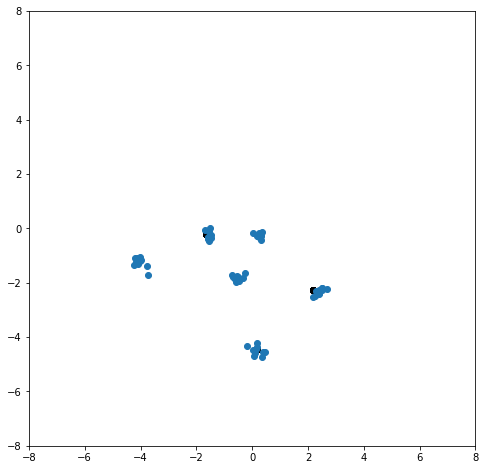

In [8]:
y_pred = model.predict(x_test)

plt.figure(figsize=(8,8))
plt.scatter(y_test[:60,0],y_test[:60,1],c='k')
plt.scatter(y_pred[:60,0],y_pred[:60,1])
plt.axis([-8,8,-8,8]);

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 100, 40)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            12864     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 64)            12352     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 128)           24704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 128)            49280     
__________

### 1.2 End-To-End model #2

In [10]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Reshape((100,40),input_shape=(40,100)))
model2.add(tf.keras.layers.Conv1D(10, 16))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(1024, activation='relu'))
model2.add(tf.keras.layers.Dense(1024, activation='relu'))
model2.add(tf.keras.layers.Dense(1024, activation='relu'))
model2.add(tf.keras.layers.Dense(1024, activation='relu'))
model2.add(tf.keras.layers.Dense(1024, activation='relu'))
model2.add(tf.keras.layers.Dense(1024, activation='relu'))
model2.add(tf.keras.layers.Dense(2))

model2.compile(optimizer='sgd', loss='mse', metrics=['mae'])
model2.fit(x_train,y_train,epochs=5)

Epoch 1/5
8000/8000 [==============================] - 24s 3ms/sample - loss: 3.6243 - mean_absolute_error: 1.2665
Epoch 2/5
8000/8000 [==============================] - 26s 3ms/sample - loss: 0.2421 - mean_absolute_error: 0.35782s - loss: 0.2522 - mean_a
Epoch 3/5
8000/8000 [==============================] - 21s 3ms/sample - loss: 0.0903 - mean_absolute_error: 0.2265
Epoch 4/5
8000/8000 [==============================] - 21s 3ms/sample - loss: 0.0506 - mean_absolute_error: 0.1730
Epoch 5/5
8000/8000 [==============================] - 22s 3ms/sample - loss: 0.0326 - mean_absolute_error: 0.1402


In [11]:
model2.evaluate(x_test,y_test)

2000/2000 [==============================] - 1s 744us/sample - loss: 0.2045 - mean_absolute_error: 0.2876


[0.20451545652747155, 0.28760067]

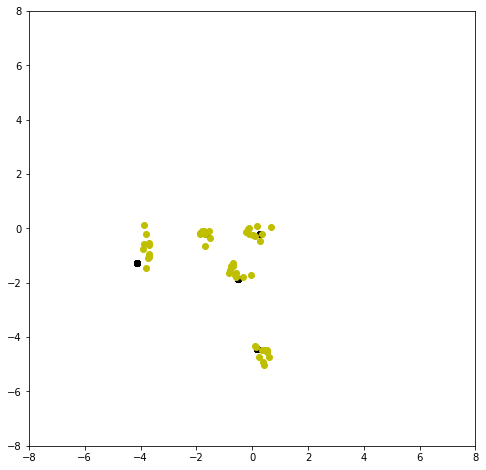

In [12]:
y_pred = model2.predict(x_test)

plt.figure(figsize=(8,8))
plt.scatter(y_test[:50,0],y_test[:50,1],c='k')
plt.scatter(y_pred[:50,0],y_pred[:50,1],c='y')
plt.axis([-8,8,-8,8]);

In [13]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 100, 40)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 85, 10)            6410      
_________________________________________________________________
flatten (Flatten)            (None, 850)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              871424    
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
__________

#### 1.3 Evaluations for different magnitude

In [1384]:
# for file in os.listdir('ZdataGen/'):
#     noise = float(file[file.find('snr')+len('snr'):file.rfind('db')])
#     if(noise==10):
#         rad = float(file[file.find('rad')+len('rad'):file.rfind('_')])
#         eval_loc.append(np.array([rad*np.cos(np.pi), rad*np.sin(np.pi)]))
#         eval_data.append(sio.loadmat('ZdataGen/'+file)['z'])
mag = 5
edata = []
for i in range(1,20+1):
    edata.append(sio.loadmat('ZdataGen/'+str(i)+'_mag'+str(mag)+'.mat')['z'])

loc_rad = sio.loadmat('ZdataGen/loc_mag'+str(mag)+'.mat')['src_locations']
eloc = np.array([loc_rad[0,:]*np.cos(loc_rad[1,:]*np.pi/180), loc_rad[0,:]*np.sin(loc_rad[1,:]*np.pi/180)])
        
eval_data = np.array(edata)
eval_loc = np.array(eloc)

xe_data = []
ye_data = []

for i in range(eval_data.shape[0]):
    for split in range(10):
        xe_data.append(eval_data[i,:,split*100:(split+1)*100])
        ye_data.append(eval_loc[:,i])
            
xe_data = np.array(xe_data)
ye_data = np.array(ye_data)

In [1239]:
model.evaluate(xe_data,ye_data)

200/200 [==============================] - 0s 1ms/sample - loss: 8.2482 - mean_absolute_error: 1.8560


[8.248215942382812, 1.8560218]

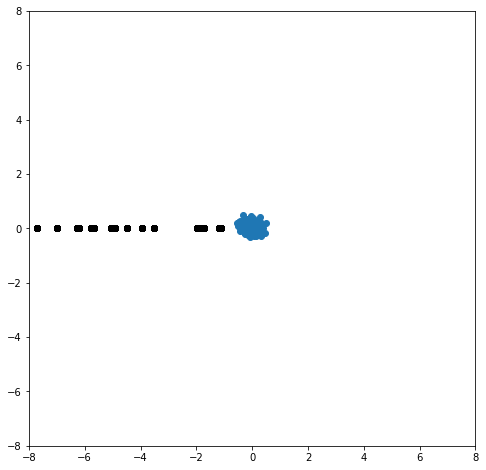

In [1240]:
pred = model.predict(xe_data)

plt.figure(figsize=(8,8))
plt.scatter(ye_data[:,0],ye_data[:,1],c='k')
plt.scatter(pred[:,0],pred[:,1])
plt.axis([-8,8,-8,8]);

### 2 Feature based DNN Localization

In [5]:
data = np.array(odata)
xf_data = []
yf_data = []
Ns = 905
fs = 1000/0.0316
t = np.linspace(0.0,Ns/fs,Ns)
x_freq = np.linspace(0,fs/2,Ns//2)

for i in range(data.shape[0]):
    for j in range(int(np.floor((data.shape[2]-905)/1))+1):
        y_datapoint = data[i,:,1*j:905+1*j]
#         xf = 2/Ns*abs(fft(y_datapoint)[:,:Ns//2])
        xf = 2/Ns*(fft(y_datapoint)[:,np.argmin(abs(x_freq-666.66))])
        xf_data.append(np.array([np.real(xf),np.imag(xf)]))
        yf_data.append(loc[:,i])          

xf_data = np.array(xf_data)
yf_data = np.array(yf_data)

### 2.1 fft feature

In [313]:
test_rat = 0.2

test_num = int(xf_data.shape[0]*test_rat)
xf_train, yf_train = shuffle(xf_data[:-test_num,:,:],yf_data[:-test_num,:],random_state=42)
xf_test = xf_data[-test_num:,:]
yf_test = yf_data[-test_num:,:]

In [309]:
model_fft = tf.keras.Sequential()
model_fft.add(tf.keras.layers.Reshape([80], input_shape=[2,40]))
# model3.add(tf.keras.layers.Conv1D(10, 16))
# model3.add(tf.keras.layers.Flatten())
model_fft.add(tf.keras.layers.Dense(1024, activation='relu'))
model_fft.add(tf.keras.layers.Dense(1024, activation='relu'))
model_fft.add(tf.keras.layers.Dropout(0.5))
model_fft.add(tf.keras.layers.Dense(1024, activation='relu'))
model_fft.add(tf.keras.layers.Dense(2))

model_fft.compile(optimizer='sgd', loss='mse', metrics=['mae'])
model_fft.fit(xf_train,yf_train,epochs=5)

Epoch 1/5
76800/76800 [==============================] - 99s 1ms/sample - loss: 0.7821 - mean_absolute_error: 0.5354
Epoch 2/5
76800/76800 [==============================] - 101s 1ms/sample - loss: 0.1540 - mean_absolute_error: 0.2909
Epoch 3/5
76800/76800 [==============================] - 96s 1ms/sample - loss: 0.1148 - mean_absolute_error: 0.2498
Epoch 4/5
76800/76800 [==============================] - 93s 1ms/sample - loss: 0.0933 - mean_absolute_error: 0.2250
Epoch 5/5
76800/76800 [==============================] - 92s 1ms/sample - loss: 0.0806 - mean_absolute_error: 0.2089


In [315]:
model_fft.evaluate(xf_test,yf_test)

19200/19200 [==============================] - 6s 332us/sample - loss: 0.2553 - mean_absolute_error: 0.3041


[0.2553184064870584, 0.30410364]

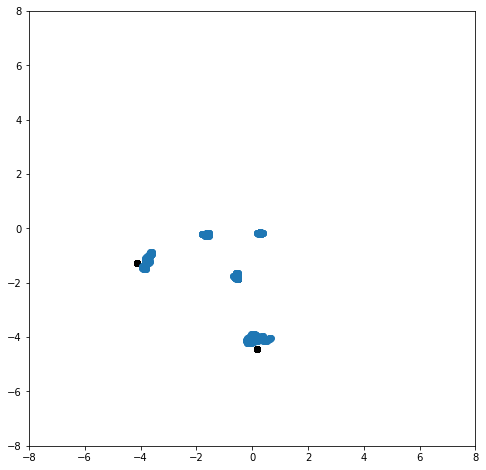

In [316]:
y_pred = model_fft.predict(xf_test)

plt.figure(figsize=(8,8))
plt.scatter(yf_test[:5*96,0],yf_test[:5*96,1],c='k')
plt.scatter(y_pred[:5*96,0],y_pred[:5*96,1])
plt.axis([-8,8,-8,8]);

### 2.2 relative fft feature

#### 2.2.1 relative fft feature num_ref = 1

In [927]:
refs = 1
xfr_data = np.zeros((xf_data.shape[0],xf_data.shape[1],int(xf_data.shape[2]*refs-refs*(refs+1)/2)))

for d in range(xf_data.shape[0]):
    c = 0
    for r in range(refs):
        for i in range(xf_data.shape[2]):
            if(i>r):
                num = np.complex(xf_data[d,0,i],xf_data[d,1,i])
                ref = np.complex(xf_data[d,0,r],xf_data[d,1,r])
                xfr_data[d,:,c] = [np.real(num/ref), np.imag(num/ref)]
                c = c+1
                
test_rat = 0.2

test_num = int(xf_data.shape[0]*test_rat)
xfr1_train, yfr1_train = shuffle(xfr_data[:-test_num,:,:],yf_data[:-test_num,:],random_state=42)
xfr1_test = xfr_data[-test_num:,:,:]
yfr1_test = yf_data[-test_num:,:]

In [318]:
model_rel1 = tf.keras.Sequential()
model_rel1.add(tf.keras.layers.Reshape([2*xfr1_train.shape[2]], input_shape=[xfr1_train.shape[1],xfr1_train.shape[2]]))
# model3.add(tf.keras.layers.Conv1D(10, 16))
# model3.add(tf.keras.layers.Flatten())
model_rel1.add(tf.keras.layers.Dense(1024, activation='relu'))
model_rel1.add(tf.keras.layers.Dense(1024, activation='relu'))
model_rel1.add(tf.keras.layers.Dropout(0.5))
model_rel1.add(tf.keras.layers.Dense(1024, activation='relu'))
model_rel1.add(tf.keras.layers.Dense(2))

model_rel1.compile(optimizer='sgd', loss='mse', metrics=['mae'])
model_rel1.fit(xfr1_train,yfr1_train,epochs=5)

Epoch 1/5
76800/76800 [==============================] - 89s 1ms/sample - loss: 0.5594 - mean_absolute_error: 0.4560
Epoch 2/5
76800/76800 [==============================] - 88s 1ms/sample - loss: 0.1326 - mean_absolute_error: 0.2669
Epoch 3/5
76800/76800 [==============================] - 89s 1ms/sample - loss: 0.0992 - mean_absolute_error: 0.2301
Epoch 4/5
76800/76800 [==============================] - 90s 1ms/sample - loss: 0.0809 - mean_absolute_error: 0.2079
Epoch 5/5
76800/76800 [==============================] - 88s 1ms/sample - loss: 0.0705 - mean_absolute_error: 0.1933


In [319]:
model_rel1.evaluate(xfr1_test,yfr1_test)

19200/19200 [==============================] - 6s 332us/sample - loss: 1.3046 - mean_absolute_error: 0.8185


[1.304574428369912, 0.81850255]

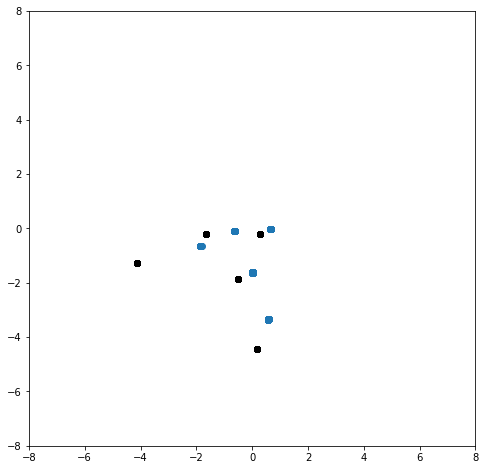

In [320]:
y1_pred = model_rel1.predict(xfr1_test)

plt.figure(figsize=(8,8))
plt.scatter(yfr1_test[:5*96,0],yfr1_test[:5*96,1],c='k')
plt.scatter(y1_pred[:5*96,0],y1_pred[:5*96,1])
plt.axis([-8,8,-8,8]);

#### 2.2.2relative fft feature num_ref = 2

In [321]:
refs = 2
xfr_data = np.zeros((xf_data.shape[0],xf_data.shape[1],int(xf_data.shape[2]*refs-refs*(refs+1)/2)))

for d in range(xf_data.shape[0]):
    c = 0
    for r in range(refs):
        for i in range(xf_data.shape[2]):
            if(i>r):
                num = np.complex(xf_data[d,0,i],xf_data[d,1,i])
                ref = np.complex(xf_data[d,0,r],xf_data[d,1,r])
                xfr_data[d,:,c] = [np.real(num/ref), np.imag(num/ref)]
                c = c+1

test_rat = 0.2

test_num = int(xf_data.shape[0]*test_rat)
xfr2_train, yfr2_train = shuffle(xfr_data[:-test_num,:,:],yf_data[:-test_num,:],random_state=42)
xfr2_test = xfr_data[-test_num:,:,:]
yfr2_test = yf_data[-test_num:,:]               

In [322]:
model_rel2 = tf.keras.Sequential()
model_rel2.add(tf.keras.layers.Reshape([2*xfr2_train.shape[2]], input_shape=[xfr2_train.shape[1],xfr2_train.shape[2]]))
# model3.add(tf.keras.layers.Conv1D(10, 16))
# model3.add(tf.keras.layers.Flatten())
model_rel2.add(tf.keras.layers.Dense(1024, activation='relu'))
model_rel2.add(tf.keras.layers.Dense(1024, activation='relu'))
model_rel2.add(tf.keras.layers.Dropout(0.5))
model_rel2.add(tf.keras.layers.Dense(1024, activation='relu'))
model_rel2.add(tf.keras.layers.Dense(2))

model_rel2.compile(optimizer='sgd', loss='mse', metrics=['mae'])
model_rel2.fit(xfr2_train,yfr2_train,epochs=5)

Epoch 1/5
76800/76800 [==============================] - 90s 1ms/sample - loss: 0.5242 - mean_absolute_error: 0.4456
Epoch 2/5
76800/76800 [==============================] - 89s 1ms/sample - loss: 0.1304 - mean_absolute_error: 0.2638
Epoch 3/5
76800/76800 [==============================] - 90s 1ms/sample - loss: 0.0976 - mean_absolute_error: 0.2272
Epoch 4/5
76800/76800 [==============================] - 90s 1ms/sample - loss: 0.0811 - mean_absolute_error: 0.2071
Epoch 5/5
76800/76800 [==============================] - 89s 1ms/sample - loss: 0.0695 - mean_absolute_error: 0.1912


In [323]:
model_rel2.evaluate(xfr2_test,yfr2_test)

19200/19200 [==============================] - 6s 335us/sample - loss: 1.4833 - mean_absolute_error: 0.8653


[1.4833182071366657, 0.86531055]

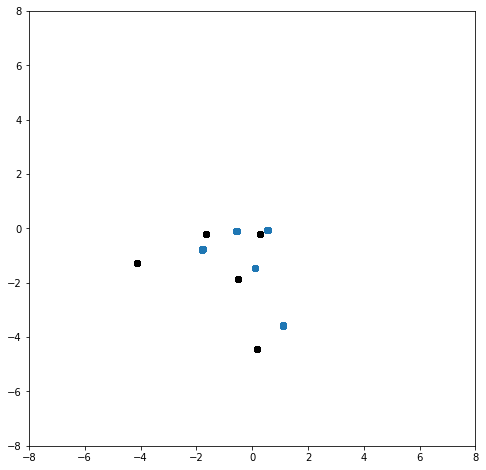

In [324]:
y2_pred = model_rel2.predict(xfr2_test)

plt.figure(figsize=(8,8))
plt.scatter(yfr2_test[:5*96,0],yfr2_test[:5*96,1],c='k')
plt.scatter(y2_pred[:5*96,0],y2_pred[:5*96,1])
plt.axis([-8,8,-8,8]);

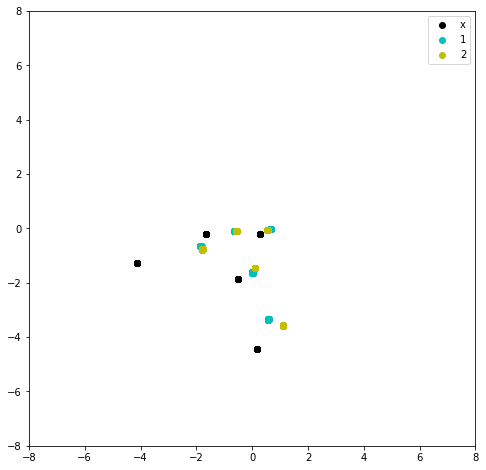

In [390]:
plt.figure(figsize=(8,8))
plt.scatter(yf_test[:5*96,0],yf_test[:5*96,1],c='k')
plt.scatter(y1_pred[:5*96,0],y1_pred[:5*96,1],c='c')
plt.scatter(y2_pred[:5*96,0],y2_pred[:5*96,1],c='y')
plt.legend(['x']+[1,2])
plt.axis([-8,8,-8,8]);

#### 2.2.3 relative fft feature num_ref = variable

In [422]:
num_refs = np.arange(1,41)

for refs in num_refs:
    
    print("number of refs : ",refs)

    xfr_data = np.zeros((xf_data.shape[0],xf_data.shape[1],int(xf_data.shape[2]*refs-refs*(refs+1)/2)))

    for d in range(xf_data.shape[0]):
        c = 0
        for r in range(refs):
            for i in range(xf_data.shape[2]):
                if(i>r): 
                    num = np.complex(xf_data[d,0,i],xf_data[d,1,i])
                    ref = np.complex(xf_data[d,0,r],xf_data[d,1,r])
                    xfr_data[d,:,c] = [np.real(num/ref), np.imag(num/ref)]
                    c = c+1

    test_rat = 0.2

    test_num = int(xf_data.shape[0]*test_rat)
    xfr_train, yfr_train = shuffle(xfr_data[:-test_num,:,:],yf_data[:-test_num,:],random_state=42)
    xfr_test = xfr_data[-test_num:,:,:]
    yfr_test = yf_data[-test_num:,:]

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Reshape([2*xfr_train.shape[2]], input_shape=[xfr_train.shape[1],xfr_train.shape[2]]))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1024, activation='relu'))
    model.add(tf.keras.layers.Dense(2))

    model.compile(optimizer='sgd', loss='mse', metrics=['mae'])
    model.fit(xfr_train,yfr_train,epochs=5)
    
    print("Test Evaluation")
    model.evaluate(xfr_test,yfr_test)

    y_pred = model.predict(xfr_test)
    
    model.save("rtf_models/"+str(refs-1)+".h5")


number of refs :  1


KeyboardInterrupt: 

In [372]:
for i in num_refs:
    model_list[i-1].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_23 (Reshape)         (None, 78)                0         
_________________________________________________________________
dense_92 (Dense)             (None, 1024)              80896     
_________________________________________________________________
dense_93 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_23 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_94 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_95 (Dense)             (None, 2)                 2050      
Total params: 2,182,146
Trainable params: 2,182,146
Non-trainable params: 0
_________________________________________________________________


dense_174 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_175 (Dense)            (None, 2)                 2050      
Total params: 3,349,506
Trainable params: 3,349,506
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_44 (Reshape)         (None, 1254)              0         
_________________________________________________________________
dense_176 (Dense)            (None, 1024)              1285120   
_________________________________________________________________
dense_177 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dropout_44 (Dropout)         (None, 1024)              0         
_________________________________________________________________


number of refs :  1
number of refs :  2
number of refs :  3
number of refs :  4
number of refs :  5
number of refs :  6
number of refs :  7
number of refs :  8
number of refs :  9
number of refs :  10
number of refs :  11
number of refs :  12
number of refs :  13
number of refs :  14
number of refs :  15
number of refs :  16
number of refs :  17
number of refs :  18
number of refs :  19
number of refs :  20
number of refs :  21
number of refs :  22
number of refs :  23
number of refs :  24
number of refs :  25
number of refs :  26
number of refs :  27
number of refs :  28
number of refs :  29
number of refs :  30
number of refs :  31
number of refs :  32
number of refs :  33
number of refs :  34
number of refs :  35
number of refs :  36
number of refs :  37
number of refs :  38
number of refs :  39
number of refs :  40


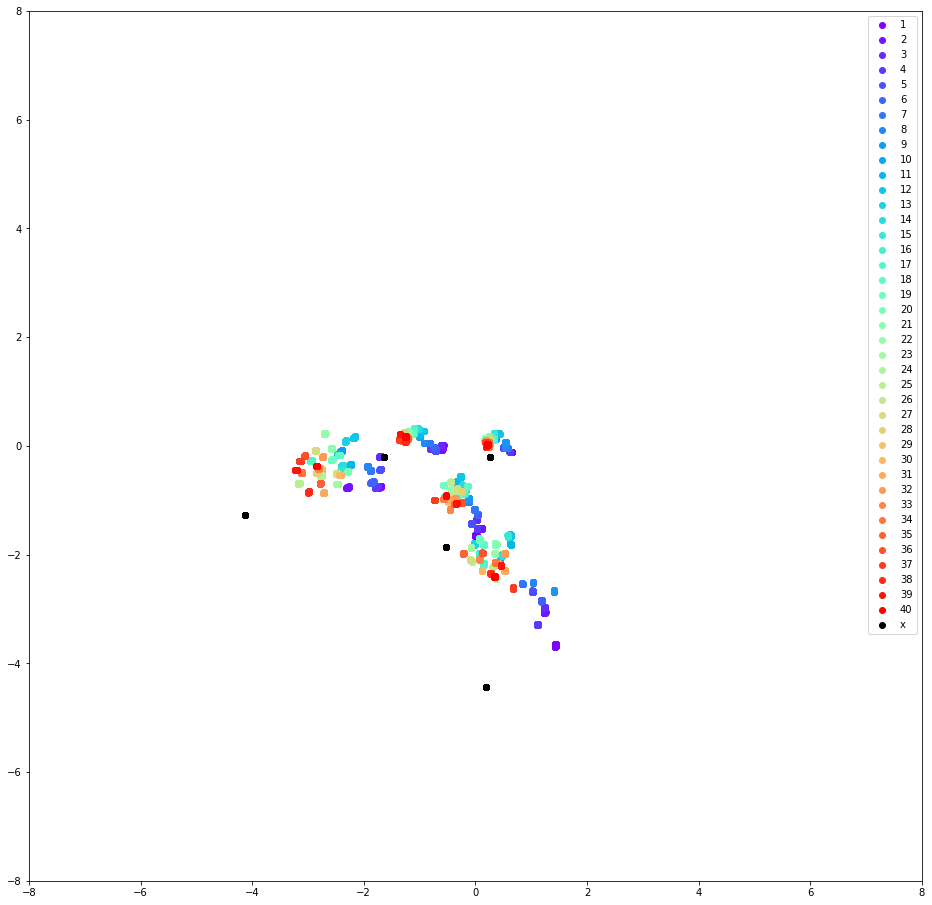

In [420]:
num_refs = np.arange(1,41)
cols = cm.rainbow(np.linspace(0, 1, len(num_refs)))

test_rat = 0.2

test_num = int(xf_data.shape[0]*test_rat)

len_ = 5

plt.figure(figsize=(16,16))
plt.axis([-8,8,-8,8]);
rel_y_pred = []

for refs,col in zip(num_refs,cols):
    
    print("number of refs : ",refs)

    xfr_data = np.zeros((xf_data.shape[0],xf_data.shape[1],int(xf_data.shape[2]*refs-refs*(refs+1)/2)))
    
    for d in range(xf_data.shape[0]):
        c = 0
        for r in range(refs):
            for i in range(xf_data.shape[2]):
                if(i>r):
                    num = np.complex(xf_data[d,0,i],xf_data[d,1,i])
                    ref = np.complex(xf_data[d,0,r],xf_data[d,1,r])
                    xfr_data[d,:,c] = [np.real(num/ref), np.imag(num/ref)]
                    c = c+1

   
    xfr_train, yfr_train = shuffle(xfr_data[:-test_num,:,:],yf_data[:-test_num,:],random_state=42)
    xfr_test = xfr_data[-test_num:,:,:]
    yfr_test = yf_data[-test_num:,:]
    
    y_pred = model_list[refs-1].predict(xfr_test[:len_*96,:,:])
    rel_y_pred.append(y_pred)
    plt.scatter(y_pred[:len_*96,0],y_pred[:len_*96,1],color=col)
    
    
plt.scatter(yfr_test[:len_*96,0],yfr_test[:len_*96,1],c='k')
plt.legend(list(num_refs)+['x'])

###### test fft

In [14]:
Ns = 905
fs = 1000/0.0316
t = np.linspace(0.0,Ns/fs,Ns)
x_freq = np.linspace(0,fs/2,Ns//2)
y = data[0,0,:Ns]
yf = 2/Ns*(fft(y)[:Ns//2])
xf = np.linspace(0,fs/2,Ns//2)
plt.plot(xf,abs(yf))

print(yf[np.argmin(abs(x_freq-666.66))])

NameError: name 'data' is not defined

### 2.3 relative stft feature

#### 2.3.1 relative fft feature num_ref = 1

In [929]:
data = np.array(odata)
x_stft_data = []
y_stft_data = []
Ns = 905
fs = 1000/0.0316
t = np.linspace(0.0,Ns/fs,Ns)
x_freq = np.linspace(0,fs/2,Ns//2)

for i in range(data.shape[0]):
    for j in range(int(np.floor((data.shape[2]-905)/1))+1):
        y_datapoint = data[i,:,1*j:905+1*j]
#         xf = 2/Ns*abs(fft(y_datapoint)[:,:Ns//2])
        xf = stft(y_datapoint)
        x_stft_data.append(xf)
        y_stft_data.append(loc[:,i])          

x_stft_data = np.array(x_stft_data)
y_stft_data = np.array(y_stft_data)

IndexError: index 2 is out of bounds for axis 1 with size 2

In [927]:
refs = 1
xfr_data = np.zeros((xf_data.shape[0],xf_data.shape[1],int(xf_data.shape[2]*refs-refs*(refs+1)/2)))

for d in range(xf_data.shape[0]):
    c = 0
    for r in range(refs):
        for i in range(xf_data.shape[2]):
            if(i>r):
                num = np.complex(xf_data[d,0,i],xf_data[d,1,i])
                ref = np.complex(xf_data[d,0,r],xf_data[d,1,r])
                xfr_data[d,:,c] = [np.real(num/ref), np.imag(num/ref)]
                c = c+1
                
test_rat = 0.2

test_num = int(xf_data.shape[0]*test_rat)
xfr1_train, yfr1_train = shuffle(xfr_data[:-test_num,:,:],yf_data[:-test_num,:],random_state=42)
xfr1_test = xfr_data[-test_num:,:,:]
yfr1_test = yf_data[-test_num:,:]

In [318]:
model_rel1 = tf.keras.Sequential()
model_rel1.add(tf.keras.layers.Reshape([2*xfr1_train.shape[2]], input_shape=[xfr1_train.shape[1],xfr1_train.shape[2]]))
# model3.add(tf.keras.layers.Conv1D(10, 16))
# model3.add(tf.keras.layers.Flatten())
model_rel1.add(tf.keras.layers.Dense(1024, activation='relu'))
model_rel1.add(tf.keras.layers.Dense(1024, activation='relu'))
model_rel1.add(tf.keras.layers.Dropout(0.5))
model_rel1.add(tf.keras.layers.Dense(1024, activation='relu'))
model_rel1.add(tf.keras.layers.Dense(2))

model_rel1.compile(optimizer='sgd', loss='mse', metrics=['mae'])
model_rel1.fit(xfr1_train,yfr1_train,epochs=5)

Epoch 1/5
76800/76800 [==============================] - 89s 1ms/sample - loss: 0.5594 - mean_absolute_error: 0.4560
Epoch 2/5
76800/76800 [==============================] - 88s 1ms/sample - loss: 0.1326 - mean_absolute_error: 0.2669
Epoch 3/5
76800/76800 [==============================] - 89s 1ms/sample - loss: 0.0992 - mean_absolute_error: 0.2301
Epoch 4/5
76800/76800 [==============================] - 90s 1ms/sample - loss: 0.0809 - mean_absolute_error: 0.2079
Epoch 5/5
76800/76800 [==============================] - 88s 1ms/sample - loss: 0.0705 - mean_absolute_error: 0.1933


In [319]:
model_rel1.evaluate(xfr1_test,yfr1_test)

19200/19200 [==============================] - 6s 332us/sample - loss: 1.3046 - mean_absolute_error: 0.8185


[1.304574428369912, 0.81850255]

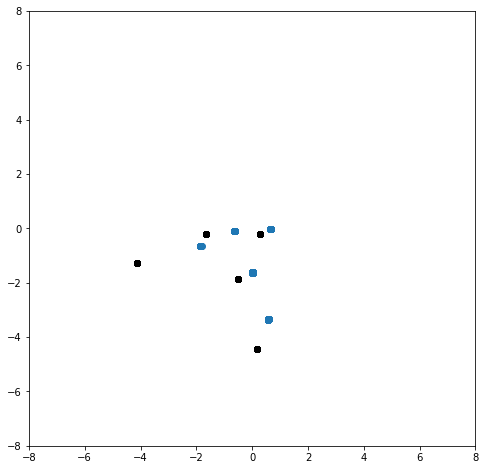

In [320]:
y1_pred = model_rel1.predict(xfr1_test)

plt.figure(figsize=(8,8))
plt.scatter(yfr1_test[:5*96,0],yfr1_test[:5*96,1],c='k')
plt.scatter(y1_pred[:5*96,0],y1_pred[:5*96,1])
plt.axis([-8,8,-8,8]);

### 2.3 Evaluations for different magnitude

test magnitude : 5
fft test
1920/1920 [==============================] - 1s 273us/sample - loss: 9.0129 - mean_absolute_error: 2.3679
test magnitude : 25
fft test
1920/1920 [==============================] - 1s 285us/sample - loss: 3.1661 - mean_absolute_error: 1.3866
test magnitude : 50
fft test
1920/1920 [==============================] - 1s 271us/sample - loss: 0.2198 - mean_absolute_error: 0.2768
fft train
76800/76800 [==============================] - 23s 296us/sample - loss: 0.0383 - mean_absolute_error: 0.1423
test magnitude : 5
rel test
1920/1920 [==============================] - 1s 291us/sample - loss: 2.3342 - mean_absolute_error: 1.0460
test magnitude : 25
rel test
1920/1920 [==============================] - 1s 284us/sample - loss: 1.1977 - mean_absolute_error: 0.8109
test magnitude : 50
rel test
1920/1920 [==============================] - 1s 302us/sample - loss: 1.2281 - mean_absolute_error: 0.8145
rel train
76800/76800 [==============================] - 24s 310us/sample

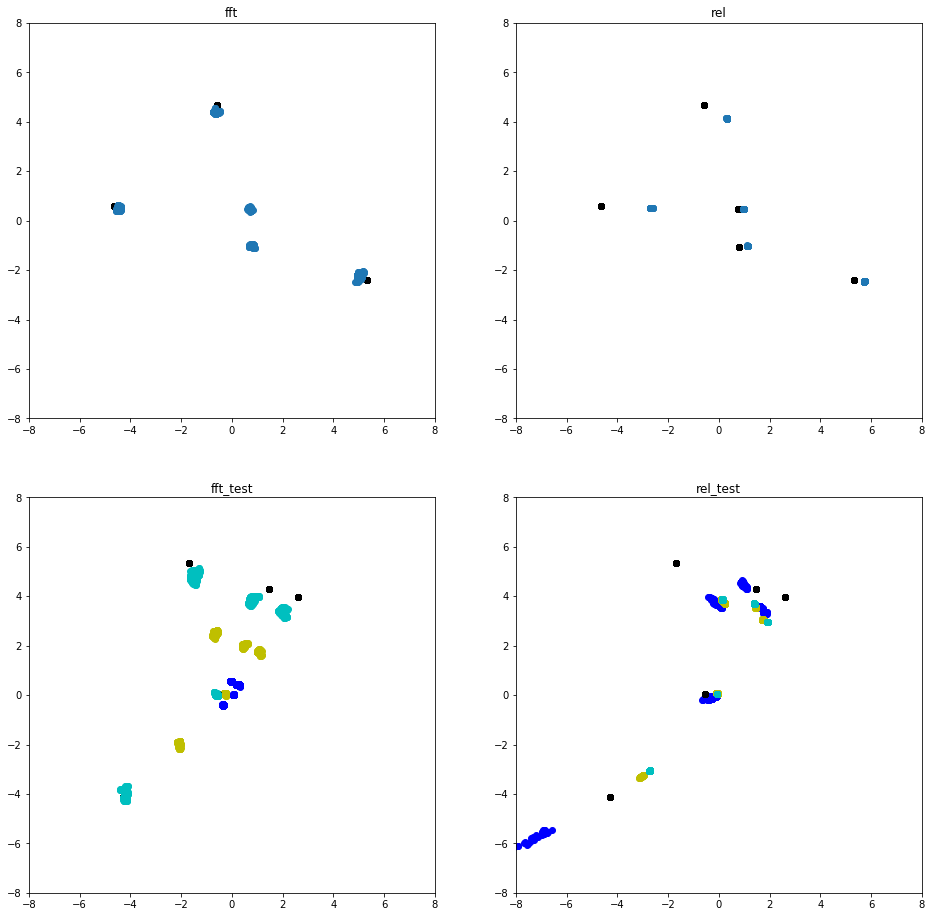

In [213]:
# for file in os.listdir('ZdataGen/'):
#     noise = float(file[file.find('snr')+len('snr'):file.rfind('db')])
#     if(noise==10):
#         rad = float(file[file.find('rad')+len('rad'):file.rfind('_')])
#         eval_loc.append(np.array([rad*np.cos(np.pi), rad*np.sin(np.pi)]))
#         eval_data.append(sio.loadmat('ZdataGen/'+file)['z'])
magnitude = [5,25,50]
col = ['b','y','c']
plt.figure(figsize=(16,16))
plt.axis([-8,8,-8,8]);

for model in ['fft','rel']:
    for dataa in ['eva','train']:
        
        if(dataa=='eva'):
            for mag,cm in zip(magnitude,col):
                edata = []
                for i in range(1,20+1):
                    edata.append(sio.loadmat('ZdataGen/'+str(i)+'_mag'+str(mag)+'.mat')['z'])

                loc_rad = sio.loadmat('ZdataGen/loc.mat')['src_locations']
                eloc = np.array([loc_rad[0,:]*np.cos(loc_rad[1,:]*np.pi/180), loc_rad[0,:]*np.sin(loc_rad[1,:]*np.pi/180)])

                eval_data = np.array(edata)
                eval_loc = np.array(eloc)
                xe_data = []
                ye_data = []
                Ns = 905
                fs = 1000/0.0316
                t = np.linspace(0.0,Ns/fs,Ns)
                x_freq = np.linspace(0,fs/2,Ns//2)

                for i in range(eval_data.shape[0]):
                    for j in range(int(np.floor((eval_data.shape[2]-905)/1))+1):
                        y_datapoint = eval_data[i,:,1*j:905+1*j]
                        xf = 2/Ns*(fft(y_datapoint)[:,np.argmin(abs(x_freq-666.66))])
                        xe_data.append(np.array([np.real(xf), np.imag(xf)]))
                        ye_data.append(eloc[:,i])          

                xe_data = np.array(xe_data)
                ye_data = np.array(ye_data)
                
                # combinations for relative fft
                refs = 2
                xer_data = np.zeros((xe_data.shape[0],xe_data.shape[1],int(xe_data.shape[2]*refs-refs*(refs+1)/2)))

                for d in range(xe_data.shape[0]):
                    c = 0
                    for r in range(refs):
                        for i in range(xe_data.shape[2]):
                            if(i>r):
                                num = np.complex(xe_data[d,0,i],xe_data[d,1,i])
                                ref = np.complex(xe_data[d,0,r],xe_data[d,1,r])
                                xer_data[d,:,c] = [np.real(num/ref), np.imag(num/ref)]
                                c = c+1
                        
                print("test magnitude : "+str(mag))
                if(model=='rel'):
                    print('rel test')
                    model_rel.evaluate(xer_data,ye_data)

                    pred = model_rel.predict(xer_data)
                    
                    ax = plt.subplot(224)
                    ax.scatter(ye_data[:5*96,0],ye_data[:5*96,1],c='k')
#                     plt.scatter(y_train[:,0],y_train[:,1],c='m')
                    ax.scatter(pred[:5*96,0],pred[:5*96,1],c=cm)
                    ax.axis([-8,8,-8,8])
                    plt.title('rel_test')
        
                else:
                    print('fft test')
                    model_fft.evaluate(xe_data,ye_data)

                    pred = model_fft.predict(xe_data)

                    ax = plt.subplot(223)
                    ax.scatter(ye_data[:5*96,0],ye_data[:5*96,1],c='k')
#                     ax.scatter(y_train[:,0],y_train[:,1],c='m')
                    ax.scatter(pred[:5*96,0],pred[:5*96,1],c=cm)
                    ax.axis([-8,8,-8,8])
                    plt.title('fft_test')
                      
            else:
                if(model=='rel'):
                    print('rel train')
                    model_rel.evaluate(xfr_train,yf_train)

                    pred = model_rel.predict(xfr_train)
                    
                    ax = plt.subplot(222)
                    ax.scatter(yf_train[:5*96,0],yf_train[:5*96,1],c='k')
#                     plt.scatter(y_train[:,0],y_train[:,1],c='m')
                    ax.scatter(pred[:5*96,0],pred[:5*96,1])
                    ax.axis([-8,8,-8,8])
                    plt.title('rel')
        
                else:
                    print('fft train')
                    model_fft.evaluate(xf_train,yf_train)

                    pred = model_fft.predict(xf_train)

                    ax = plt.subplot(221)
                    ax.scatter(yf_train[:5*96,0],yf_train[:5*96,1],c='k')
#                     ax.scatter(y_train[:,0],y_train[:,1],c='m')
                    ax.scatter(pred[:5*96,0],pred[:5*96,1])
                    ax.axis([-8,8,-8,8])
                    plt.title('fft')


## 3 Encoder-Decoder RTF Model

### 3.1 Encoder 

#### 3.1.1 refs = 2

In [6]:
refs = 2

xfr_data = np.zeros((xf_data.shape[0],3,int(xf_data.shape[2]*refs-refs*(refs+1)/2)))

for d in range(xf_data.shape[0]):
    c = 0
    for r in range(refs):
        for i in range(xf_data.shape[2]):
            if(i>r):
                num = np.complex(xf_data[d,0,i],xf_data[d,1,i])
                ref = np.complex(xf_data[d,0,r],xf_data[d,1,r])
                xfr_data[d,:,c] = [20*np.log10(abs(num/ref)), np.cos(np.angle(num/ref)), np.sin(np.angle(num/ref))]
                c = c+1

test_rat = 0.2

test_num = int(xf_data.shape[0]*test_rat)
xfr2_train, yfr2_train = shuffle(xfr_data[:-test_num,:,:],yf_data[:-test_num,:],random_state=42)
xfr2_test = xfr_data[-test_num:,:,:]
yfr2_test = yf_data[-test_num:,:]               

In [21]:
enc = tf.keras.Sequential([
    tf.keras.layers.Reshape([xfr2_train.shape[1]*xfr2_train.shape[2]], input_shape=[xfr2_train.shape[1],xfr2_train.shape[2]]),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2)
])

enc.compile(optimizer='adam', loss='mse', metrics=['mae'])
enc.fit(xfr2_train,yfr2_train,epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
76800/76800 [==============================] - 15s 198us/sample - loss: 0.1056 - mean_absolute_error: 0.1526
Epoch 2/5
76800/76800 [==============================] - 15s 190us/sample - loss: 0.0116 - mean_absolute_error: 0.0749
Epoch 3/5
76800/76800 [==============================] - 15s 193us/sample - loss: 0.0082 - mean_absolute_error: 0.0658
Epoch 4/5
76800/76800 [==============================] - 15s 198us/sample - loss: 0.0057 - mean_absolute_error: 0.0566
Epoch 5/5
76800/76800 [==============================] - 15s 195us/sample - loss: 0.0045 - mean_absolute_error: 0.0508


In [22]:
enc.evaluate(xfr2_test,yfr2_test)

19200/19200 [==============================] - 2s 78us/sample - loss: 0.0417 - mean_absolute_error: 0.1028


[0.04172161266583013, 0.102787785]

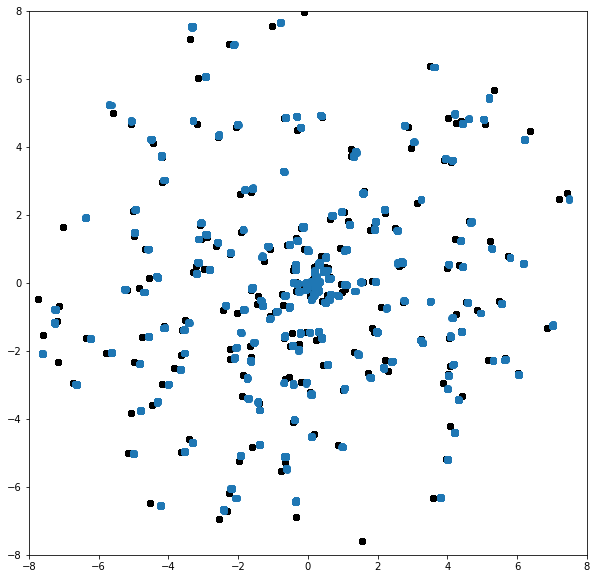

In [26]:
y2_pred = enc.predict(xfr2_test)

plt.figure(figsize=(10,10))
plt.scatter(yfr2_test[:,0],yfr2_test[:,1],c='k')
plt.scatter(y2_pred[:,0],y2_pred[:,1])
plt.axis([-8,8,-8,8]);

#### 3.1.2 refs = variable

1
Epoch 1/5
76800/76800 [==============================] - 31s 400us/sample - loss: 0.0722 - mean_absolute_error: 0.1367
Epoch 2/5
76800/76800 [==============================] - 25s 323us/sample - loss: 0.0144 - mean_absolute_error: 0.0816
Epoch 3/5
76800/76800 [==============================] - 25s 321us/sample - loss: 0.0096 - mean_absolute_error: 0.0649
Epoch 4/5
76800/76800 [==============================] - 25s 332us/sample - loss: 0.0067 - mean_absolute_error: 0.0602
Epoch 5/5
76800/76800 [==============================] - 25s 322us/sample - loss: 0.0048 - mean_absolute_error: 0.0516
test evaluate
19200/19200 [==============================] - 3s 181us/sample - loss: 0.0321 - mean_absolute_error: 0.0914
5
Epoch 1/5
76800/76800 [==============================] - 41s 534us/sample - loss: 0.1685 - mean_absolute_error: 0.1930
Epoch 2/5
76800/76800 [==============================] - 40s 523us/sample - loss: 0.0133 - mean_absolute_error: 0.0788
Epoch 3/5
76800/76800 [==================

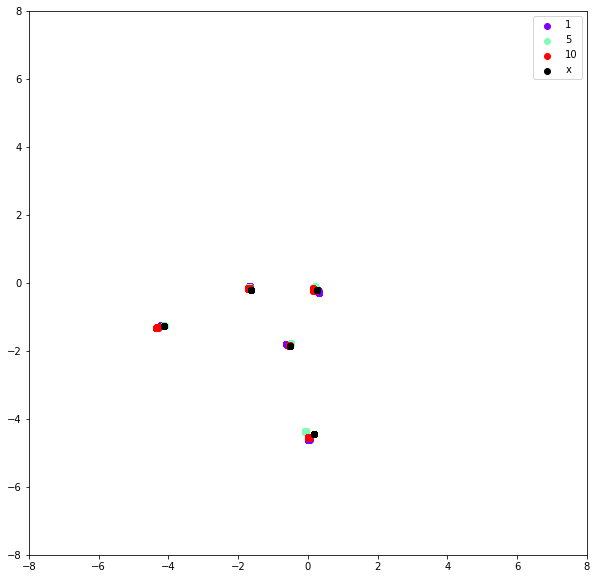

In [464]:
num_refs = [1,5,10]
cols = cm.rainbow(np.linspace(0, 1, len(num_refs)))
enc_list = []

plt.figure(figsize=(10,10))

for refs,col in zip(num_refs,cols):
    print(refs)
    
    xfr_data = np.zeros((xf_data.shape[0],3,int(xf_data.shape[2]*refs-refs*(refs+1)/2)))

    for d in range(xf_data.shape[0]):
        c = 0
        for r in range(refs):
            for i in range(xf_data.shape[2]):
                if(i>r):
                    num = np.complex(xf_data[d,0,i],xf_data[d,1,i])
                    ref = np.complex(xf_data[d,0,r],xf_data[d,1,r])
                    xfr_data[d,:,c] = [20*np.log10(abs(num/ref)), np.cos(np.angle(num/ref)), np.sin(np.angle(num/ref))]
                    c = c+1

    test_rat = 0.2

    test_num = int(xf_data.shape[0]*test_rat)
    xfr_train, yfr_train = shuffle(xfr_data[:-test_num,:,:],yf_data[:-test_num,:],random_state=42)
    xfr_test = xfr_data[-test_num:,:,:]
    yfr_test = yf_data[-test_num:,:]               

    enc = tf.keras.Sequential([
        tf.keras.layers.Reshape([xfr_train.shape[1]*xfr_train.shape[2]], input_shape=[xfr_train.shape[1],xfr_train.shape[2]]),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(2)
    ])

    enc.compile(optimizer='adam', loss='mse', metrics=['mae'])
    enc.fit(xfr_train,yfr_train,epochs=5) 
    
    enc_list.append(enc)
    
    print('test evaluate')
    enc.evaluate(xfr_test,yfr_test)
    
    y_pred = enc.predict(xfr_test)
    
    plt.scatter(y_pred[:5*96,0],y_pred[:5*96,1],color=col)
    
plt.scatter(yfr_test[:5*96,0],yfr_test[:5*96,1],c='k')
plt.axis([-8,8,-8,8]);
plt.legend(list(num_refs)+['x'])

refs  1
test magnitude : 5
1920/1920 [==============================] - 0s 177us/sample - loss: 0.2202 - mean_absolute_error: 0.3541
test magnitude : 25
1920/1920 [==============================] - 0s 177us/sample - loss: 0.0168 - mean_absolute_error: 0.0954
test magnitude : 50
1920/1920 [==============================] - ETA: 0s - loss: 0.0089 - mean_absolute_error: 0.080 - 0s 186us/sample - loss: 0.0086 - mean_absolute_error: 0.0784
refs  5
test magnitude : 5
1920/1920 [==============================] - 1s 275us/sample - loss: 0.1849 - mean_absolute_error: 0.3367
test magnitude : 25
1920/1920 [==============================] - 1s 282us/sample - loss: 0.0200 - mean_absolute_error: 0.1115
test magnitude : 50
1920/1920 [==============================] - 1s 287us/sample - loss: 0.0197 - mean_absolute_error: 0.1105
refs  10
test magnitude : 5
1920/1920 [==============================] - 1s 344us/sample - loss: 0.1567 - mean_absolute_error: 0.3001
test magnitude : 25
1920/1920 [===========

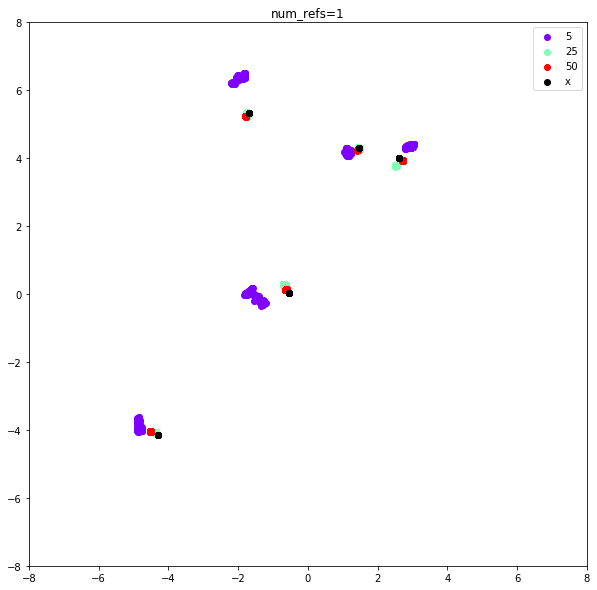

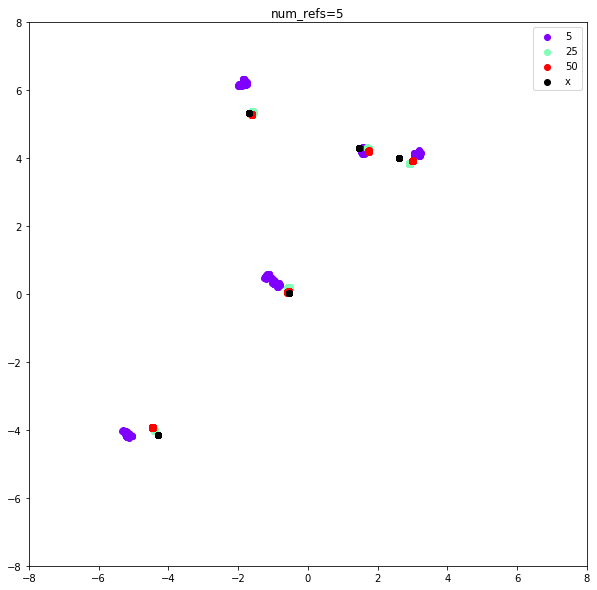

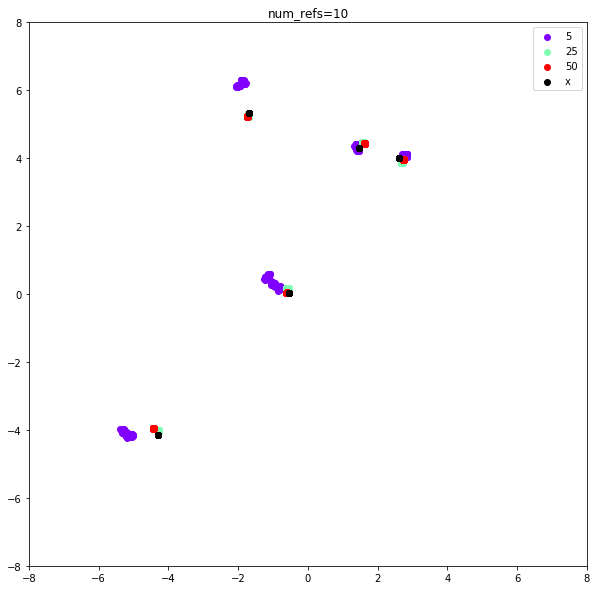

In [466]:
magnitude = [5,25,50]
cols = cm.rainbow(np.linspace(0, 1, len(magnitude)))

for refs,enc in zip(num_refs,enc_list):
    
    print("refs ",refs)
    plt.figure(figsize=(10,10))
    
    for mag,col in zip(magnitude,cols):
        
        edata = []
        for i in range(1,20+1):
            edata.append(sio.loadmat('ZdataGen/'+str(i)+'_mag'+str(mag)+'.mat')['z'])

        loc_rad = sio.loadmat('ZdataGen/loc.mat')['src_locations']
        eloc = np.array([loc_rad[0,:]*np.cos(loc_rad[1,:]*np.pi/180), loc_rad[0,:]*np.sin(loc_rad[1,:]*np.pi/180)])

        eval_data = np.array(edata)
        eval_loc = np.array(eloc)
        xe_data = []
        ye_data = []
        Ns = 905
        fs = 1000/0.0316
        t = np.linspace(0.0,Ns/fs,Ns)
        x_freq = np.linspace(0,fs/2,Ns//2)

        for i in range(eval_data.shape[0]):
            for j in range(int(np.floor((eval_data.shape[2]-905)/1))+1):
                y_datapoint = eval_data[i,:,1*j:905+1*j]
                xf = 2/Ns*(fft(y_datapoint)[:,np.argmin(abs(x_freq-666.66))])
                xe_data.append(np.array([np.real(xf), np.imag(xf)]))
                ye_data.append(eloc[:,i])          

        xe_data = np.array(xe_data)
        ye_data = np.array(ye_data)

        # combinations for relative fft
        xer_data = np.zeros((xe_data.shape[0],3,int(xe_data.shape[2]*refs-refs*(refs+1)/2)))

        for d in range(xe_data.shape[0]):
            c = 0
            for r in range(refs):
                for i in range(xe_data.shape[2]):
                    if(i>r):
                        num = np.complex(xe_data[d,0,i],xe_data[d,1,i])
                        ref = np.complex(xe_data[d,0,r],xe_data[d,1,r])
                        xer_data[d,:,c] = [20*np.log10(abs(num/ref)), np.cos(np.angle(num/ref)), np.sin(np.angle(num/ref))]
                        c = c+1

        print("test magnitude : "+str(mag))
        enc.evaluate(xer_data,ye_data)

        pred = enc.predict(xer_data)
        
        plt.scatter(pred[:5*96,0],pred[:5*96,1],color=col)
        
    plt.scatter(ye_data[:5*96,0],ye_data[:5*96,1],c='k')
    plt.axis([-8,8,-8,8])
    plt.title('num_refs='+str(refs))
    plt.legend(list(magnitude)+['x'])

### 3.2 Supervised Autoencoders


#### 3.1.1 refs = 2

In [8]:
refs = 2

xfr_data = np.zeros((xf_data.shape[0],3,int(xf_data.shape[2]*refs-refs*(refs+1)/2)))

for d in range(xf_data.shape[0]):
    c = 0
    for r in range(refs):
        for i in range(xf_data.shape[2]):
            if(i>r):
                num = np.complex(xf_data[d,0,i],xf_data[d,1,i])
                ref = np.complex(xf_data[d,0,r],xf_data[d,1,r])
                xfr_data[d,:,c] = [20*np.log10(abs(num/ref)), np.cos(np.angle(num/ref)), np.sin(np.angle(num/ref))]
                c = c+1

test_rat = 0.2

test_num = int(xf_data.shape[0]*test_rat)
xfr_train, yfr_train = shuffle(xfr_data[:-test_num,:,:],yf_data[:-test_num,:],random_state=42)
xfr_test = xfr_data[-test_num:,:,:]
yfr_test = yf_data[-test_num:,:]               

In [12]:
from keras.layers import Input, Dense, concatenate, Reshape
from keras.models import Model
        
inputs = Input(shape=(xfr_train.shape[1],xfr_train.shape[2]))
enc_in = Reshape([xfr_train.shape[1]*xfr_train.shape[2]])(inputs)
enc_1 = Dense(1024, activation='relu')(enc_in)
aux_layer = Dense(2, name="aux_layer")(enc_1)
dec_1 = Dense(1024, activation='relu')(aux_layer)
dec_out = Dense(xfr_train.shape[1]*xfr_train.shape[2])(dec_1)
output = Reshape([xfr_train.shape[1],xfr_train.shape[2]])(dec_out)

sae = Model(inputs=inputs, outputs=[output,aux_layer])

sae.compile(optimizer='adam', loss=['mse','mse'], loss_weights=[1,1])
sae.fit(xfr_train,[xfr_train,yfr_train],epochs=5)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
76800/76800 [==============================] - 27s 347us/step - loss: 0.8862 - reshape_4_loss: 0.7007 - aux_layer_loss: 0.1855
Epoch 2/5
76800/76800 [==============================] - 27s 348us/step - loss: 0.3776 - reshape_4_loss: 0.3501 - aux_layer_loss: 0.0275
Epoch 3/5
76800/76800 [==============================] - 28s 359us/step - loss: 0.3363 - reshape_4_loss: 0.3180 - aux_layer_loss: 0.0183
Epoch 4/5
76800/76800 [==============================] - 28s 366us/step - loss: 0.3178 - reshape_4_loss: 0.3025 - aux_layer_loss: 0.0152
Epoch 5/5
76800/76800 [==============================] - 28s 358us/step - loss: 0.2975 - reshape_4_loss: 0.2861 - aux_layer_loss: 0.0114


In [14]:
sae.evaluate(xfr_test,[xfr_test,yfr_test])

19200/19200 [==============================] - 2s 98us/step


[0.3954578626031677, 0.3508379356438915, 0.044619927105037885]

[ 5.115103    7.939866    8.698673    8.734691    8.783417    8.399196
  5.7380543   1.0309949  -1.6984946   0.76333475  5.866469    9.037006
  9.887496    9.823863   10.151799   10.009126    8.336087    4.8468294
  2.7376664   4.7044554   8.334365   10.167414   10.484527   10.366109
 10.218032    9.5706      7.611293    3.842718    2.0397382   4.0019307
  7.194052    8.684076    8.859735    8.571245    8.754757    7.970421
  5.076106    0.03493157 -2.5204515   2.8738112   3.6201146   3.6376295
  3.6922843   3.3276534   0.66250134 -4.0505285  -6.7903824  -4.319003
  0.76106304  3.9494402   4.775295    4.715929    5.0611997   4.9095535
  3.2209933  -0.29878485 -2.380197   -0.4180707   3.2122493   5.0429177
  5.381432    5.257688    5.079063    4.456057    2.4995205  -1.2559718
 -3.0903864  -1.1094977   2.086214    3.5624328   3.7527509   3.4472728
  3.6328948   2.8328044  -0.06436943 -5.0991297  -7.652352  ]
[ 5.14073983  7.82250413  8.67001758  8.63647543  8.76091321  8.29099271
  5.60

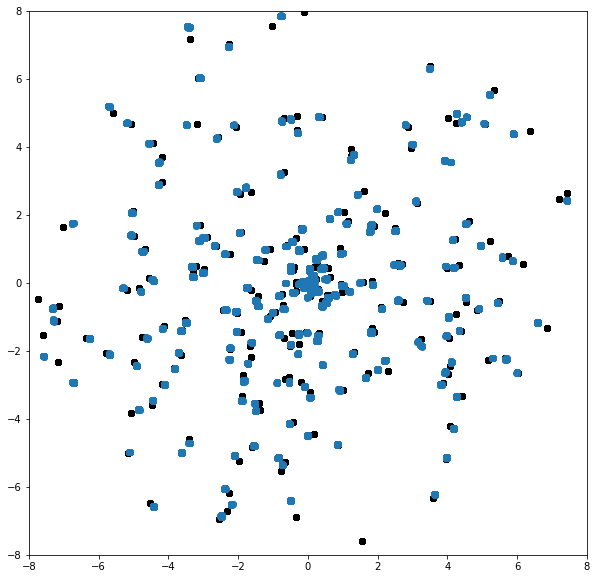

In [25]:
x_pred, y_pred = sae.predict(xfr_test)

print(x_pred[0,0,:])
print(xfr_test[0,0,:])

plt.figure(figsize=(10,10))
plt.scatter(yfr2_test[:,0],yfr2_test[:,1],c='k')
plt.scatter(y_pred[:,0],y_pred[:,1])
plt.axis([-8,8,-8,8]);

### 3.3 Multi Source n = 2

In [27]:
xf_data.shape

(96000, 2, 40)

In [3]:
dir_ = os.getcwd()+'\\CIPIC_hrtf_database\\standard_hrir_database\\'
hrir_data = []
hrir = []
loc = []

for files in os.listdir(dir_):
    if(files[:7]=='subject'):
        hrir.append([sio.loadmat(dir_+files+'\\hrir_final.mat')['hrir_r'],
                          sio.loadmat(dir_+files+'\\hrir_final.mat')['hrir_l']]) 

hrir = np.array(hrir)
azimuth = np.concatenate((np.array([-85,-65,-55]),np.arange(-45,50,5),np.array([55,65,85])))
elevation = (-45 + 5.625*np.arange(0,50,1))

# for d in range(hrir.shape[0]):
for a in range(hrir.shape[2]):
    for e in range(hrir.shape[3]):
#             x = 1 * np.cos(elevation[e]) * np.cos(azimuth[a])
#             y = 1 * np.cos(elevation[e]) * np.sin(azimuth[a])
#             z = 1 * np.sin(elevation[e])
#             loc.append([x,y,z])
        if(elevation[e]<=90 and elevation[e]>=-45):
            loc.append([azimuth[a],elevation[e]])
            hrir_data.append(hrir[0,:,a,e,:])
    
hrir_data = np.array(hrir_data)
loc = np.array(loc)*np.pi/180

Ns = 200
fs = 44.1e3
t = np.linspace(0.0,Ns/fs,Ns)
x_freq = np.linspace(0,fs/2,Ns//2)
xf = np.linspace(0,fs/2,Ns//2)

hrtf_data = np.zeros((hrir_data.shape[0],hrir_data.shape[1],2,Ns//2))

for d in range(hrir_data.shape[0]):
    for sen in range(hrir_data.shape[1]):
        y = hrir_data[d,sen,:]
        yf = 2/Ns*(fft(y)[:Ns//2])
        hrtf_data[d,sen,0,:] = np.real(yf)
        hrtf_data[d,sen,1,:] = np.imag(yf)

In [4]:
azimuth.shape

(25,)

In [5]:
# encoder dataset
refs = 1

rtf_data = np.zeros((hrtf_data.shape[0],int(hrtf_data.shape[1]*refs-refs*(refs+1)/2),3,hrtf_data.shape[3]))

for d in range(hrtf_data.shape[0]):
    c = 0
    for r in range(refs):
        for i in range(hrtf_data.shape[1]):
            if(i>r):
                num = np.array([complex(rl,ig) for rl,ig in zip(hrtf_data[d,i,0,:],hrtf_data[d,i,1,:])])
                ref = np.array([complex(rl,ig) for rl,ig in zip(hrtf_data[d,r,0,:],hrtf_data[d,r,1,:])])
                rtf = num/ref
                rtf_data[d,c,:,:] = np.array([20*np.log10(abs(rtf)), np.cos(np.angle(rtf)), np.sin(np.angle(rtf))])
                c = c+1

test_rat = 0.2

test_num = int(rtf_data.shape[0]*test_rat)
xr_train, yr_train = shuffle(rtf_data[:,:,:,:],loc[:,:],random_state=42)
xr_test = rtf_data[-test_num:,:,:,:]
yr_test = loc[-test_num:,:]               

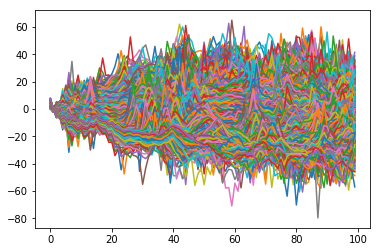

In [6]:
plt.plot(rtf_data[:,0,0,:].T);

In [7]:
enc = tf.keras.Sequential([
    tf.keras.layers.Reshape([xr_train.shape[1]*xr_train.shape[2]*xr_train.shape[3]], input_shape=(xr_train.shape[1],xr_train.shape[2],xr_train.shape[3])),
#     tf.keras.layers.Convolution1D(64,10, activation='relu'),
#     tf.keras.layers.MaxPool1D(3),
#     tf.keras.layers.Convolution1D(64,10, activation='relu'),
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2)
])

enc.compile(optimizer='adam', loss='mse', metrics=['mae'])
enc.fit(xr_train,yr_train,epochs=5)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
625/625 [==============================] - 1s 1ms/sample - loss: 160.2989 - mean_absolute_error: 7.1511
Epoch 2/5
625/625 [==============================] - 1s 1ms/sample - loss: 1.9627 - mean_absolute_error: 1.0634
Epoch 3/5
625/625 [==============================] - 1s 1ms/sample - loss: 0.5820 - mean_absolute_error: 0.5795
Epoch 4/5
625/625 [==============================] - 1s 1ms/sample - loss: 0.3634 - mean_absolute_error: 0.4467
Epoch 5/5
625/625 [==============================] - 1s 1ms/sample - loss: 0.2781 - mean_absolute_error: 0.3848


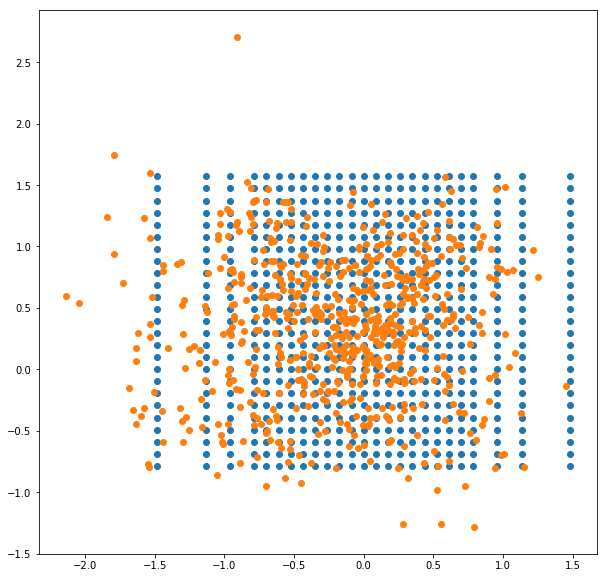

In [8]:
y_pred = enc.predict(xr_train)

plt.figure(figsize=(10,10))
plt.scatter(yr_train[:,0],yr_train[:,1])
plt.scatter(y_pred[:,0],y_pred[:,1])

Text(0.5, 1.0, 'ele')

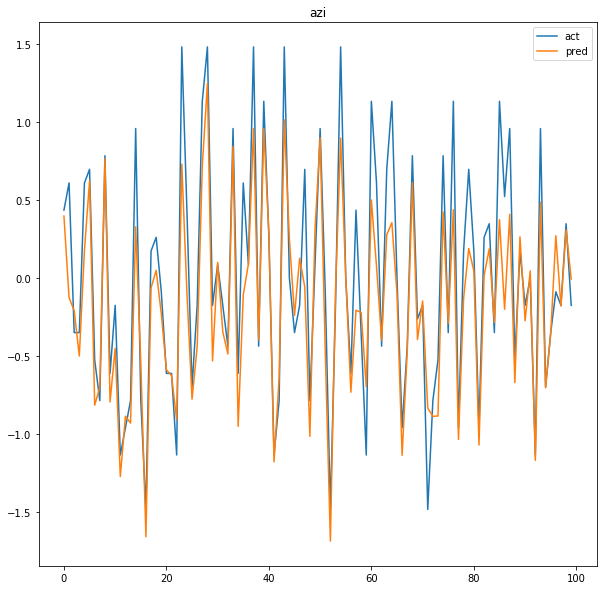

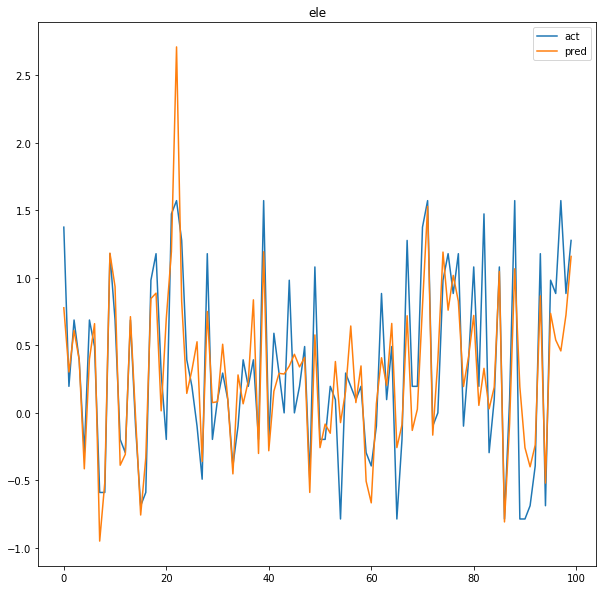

In [9]:
y_pred = enc.predict(xr_train)

plt.figure(figsize=(10,10))
plt.plot(yr_train[:100,0])
plt.plot(y_pred[:100,0])
plt.legend(['act','pred'])
plt.title('azi')
plt.figure(figsize=(10,10))
plt.plot(yr_train[:100,1])
plt.plot(y_pred[:100,1])
plt.legend(['act','pred'])
plt.title('ele')
# plt.axis([-1,1,-1,1]);

In [10]:
# decoder dataset
test_rat = 0.2

test_num = int(hrtf_data.shape[0]*test_rat)
x_train, y_train = shuffle(hrtf_data[:,:,:,:],loc[:,:],random_state=42)
x_test = hrtf_data[-test_num:,:,:,:]
y_test = loc[-test_num:,:] 

In [11]:
dec = tf.keras.Sequential([
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(x_train.shape[3]*x_train.shape[1]*x_train.shape[2]),
    tf.keras.layers.Reshape([x_train.shape[1],x_train.shape[2],x_train.shape[3]])
])

dec.compile(optimizer='adam', loss='mse', metrics=['mae'])
dec.fit(y_train,x_train,epochs=5)

Epoch 1/5
625/625 [==============================] - 2s 3ms/sample - loss: 1.5004e-04 - mean_absolute_error: 0.0082
Epoch 2/5
625/625 [==============================] - 1s 2ms/sample - loss: 1.0858e-04 - mean_absolute_error: 0.0066
Epoch 3/5
625/625 [==============================] - 1s 2ms/sample - loss: 1.0538e-04 - mean_absolute_error: 0.0064
Epoch 4/5
625/625 [==============================] - 1s 2ms/sample - loss: 1.0267e-04 - mean_absolute_error: 0.0063
Epoch 5/5
625/625 [==============================] - 1s 2ms/sample - loss: 1.0044e-04 - mean_absolute_error: 0.0062


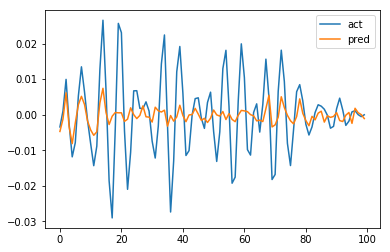

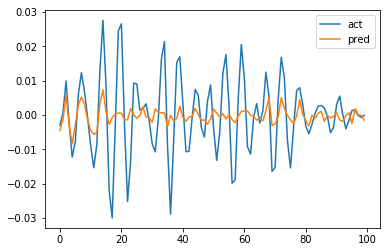

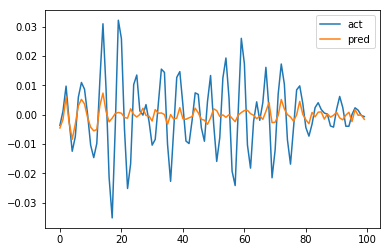

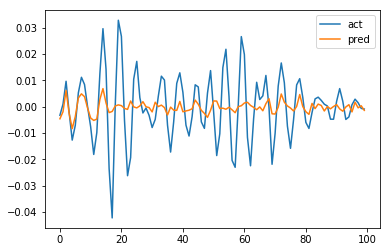

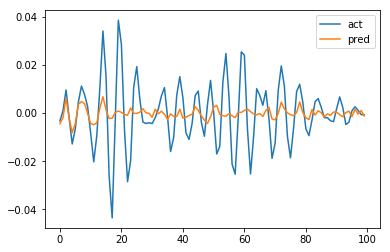

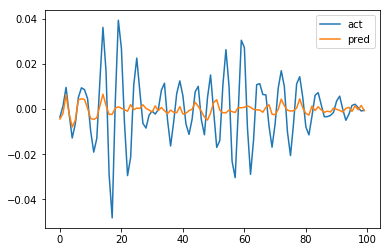

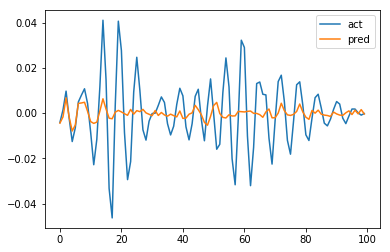

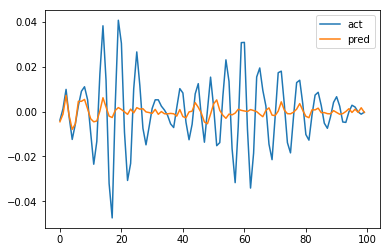

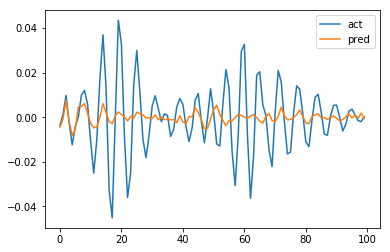

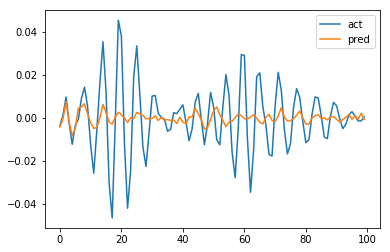

In [12]:
dec_pred = dec.predict(y_test)

for i in range(10):
    plt.figure()
    plt.plot(x_test[i,0,0,:])
    plt.plot(dec_pred[i,0,0,:])
    plt.legend(['act','pred'])

In [13]:
numtaps = 200
fs = 44.1e3

# filters for white noise
np.random.seed(10)
f1 = np.random.randn(100)
np.random.seed(20)
f2 = np.random.randn(100)

# white noise
np.random.seed(41)
wn1 = np.random.randn(100000)
np.random.seed(42)
wn2 = np.random.randn(100000)

# source signals 
s1 = np.convolve(wn1,f1,mode='same')
s2 = np.convolve(wn2,f2,mode='same')

# random two indices
li1 = 408
# np.random.randint(0,loc.shape[0])
li2 = 108
# np.random.randint(0,loc.shape[0])

#random two locations
d1 = loc[li1,:]*180/np.pi
d2 = loc[li2,:]*180/np.pi

# random two impulse responses
h1 = hrir_data[li1,:,:]
h2 = hrir_data[li2,:,:]
    
# the recorded signal genrated from the random source signals at two random location
y = np.zeros((h1.shape[0],s1.shape[0]))
for s in range(h1.shape[0]):
    y[s,:] = np.convolve(h1[s,:],s1,mode='same') + np.convolve(h2[s,:],s2,mode='same')

# the stft of the synthesized recorded signal
Y = []
for s in range(y.shape[0]):    
    f,t,Zxx = stft(y[s,:],fs,nperseg=200)
    Y.append(Zxx)
Y_stft = np.array(Y,dtype=np.complex_)
Y = np.mean(Y_stft[:,:-1,:], axis=-1)
    
# corresponding two random signal ATFs at two locations
H1 = np.zeros((hrtf_data.shape[1],hrtf_data.shape[3]),dtype=np.complex_)
H2 = np.zeros((hrtf_data.shape[1],hrtf_data.shape[3]),dtype=np.complex_)
for s in range(hrtf_data.shape[1]):
    for i in range(hrtf_data.shape[3]):
        H1[s,i] = complex(hrtf_data[li1,s,0,i],hrtf_data[li1,s,1,i])
        H2[s,i] = complex(hrtf_data[li2,s,0,i],hrtf_data[li2,s,1,i])

# the ft of the source signal
Ns = 200
S1 = np.array(2/Ns*fft(s1,n=Ns)[:Ns//2],dtype=np.complex_)
# f,t,S1 = stft(s1,fs,nperseg=200)
# S1 = np.mean(S1[:-1,:], axis=-1)
S2 = np.array(2/Ns*fft(s2,n=Ns)[:Ns//2],dtype=np.complex_)
# f,t,S2 = stft(s2,fs,nperseg=200)
# S2 = np.mean(S2[:-1,:], axis=-1)

# decoder dictionary pos->atf
get_pos = loc*180/np.pi
get_atf = np.zeros((hrtf_data.shape[0],hrtf_data.shape[1],hrtf_data.shape[3]),dtype=np.complex_)
for d in range(hrtf_data.shape[0]):
    for s in range(hrtf_data.shape[1]):
        for i in range(hrtf_data.shape[3]):
            get_atf[d,s,i] = complex(hrtf_data[d,s,0,i],hrtf_data[d,s,1,i])
            
# encoder dictionary rtf->pos
get_pos = loc*180/np.pi
get_rtf = np.zeros((rtf_data.shape[0],rtf_data.shape[2],rtf_data.shape[3]))
for d in range(hrtf_data.shape[0]):
    num = np.array([complex(rl,ig) for rl,ig in zip(hrtf_data[d,0,0,:],hrtf_data[d,0,1,:])])
    ref = np.array([complex(rl,ig) for rl,ig in zip(hrtf_data[d,1,0,:],hrtf_data[d,1,1,:])])
    rtf = num/ref
    get_rtf[d,:,:] = np.array([20*np.log10(abs(rtf)), np.cos(np.angle(rtf)), np.sin(np.angle(rtf))])

C:\Users\Tarunbir Singh\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:153: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[index]


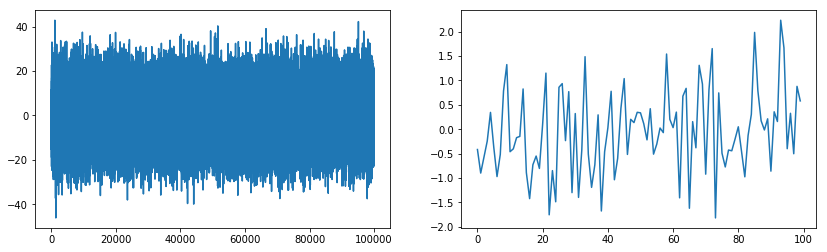

In [14]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(s1)
plt.subplot(122)
plt.plot(np.real(S1))

[20.  0.]
[-85.   0.] (0.0014646144758323966-0j)
[-85.   0.] (-0.0034985676834384527+0j)
~~~~~~~~~~~~~~~~~~~~~~~~~
[-85.   0.]
[-85.   0.] (0.00222247557802447-0j)
[-85.   0.] (-0.003841490553845232+0j)
~~~~~~~~~~~~~~~~~~~~~~~~~
[-85.   0.]
[-85.   0.] (0.00222247557802447-0j)
[-85.   0.] (-0.003841490553845232+0j)
~~~~~~~~~~~~~~~~~~~~~~~~~


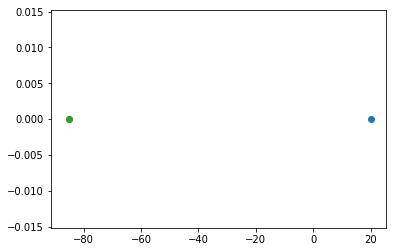

In [15]:
Se1 = S1
# np.array([complex(np.random.rand(),np.random.rand()) for i in range(Y.shape[1])])
de1 = d1 
c = 0

while(True): 
    
    c=c+1
    
    print(de1)
    
    plt.scatter(de1[0],de1[1])
    
    ### Block 1 ###
     
    # decoder
    He1 = get_atf[np.argmin([np.linalg.norm(loci-de1) for loci in get_pos]),:,:]
    Se1He1 = Se1*He1  
    
    rtf2_e = np.zeros((3,Y.shape[1]))
    for freq in range(Y.shape[1]):
        n = Y[0,freq] - Se1He1[0,freq] 
        d = Y[1,freq] - Se1He1[1,freq]
        rtf2_e[:,freq] = np.array([20*np.log10(abs(n/d)), np.cos(np.angle(n/d)), np.sin(np.angle(n/d))])

    # encoder
    de2 = get_pos[np.argmin([sum(sum(rtf_i - rtf2_e)) for rtf_i in get_rtf]),:]
    print(de2, Se1He1[0,0])
     
    ### Block 2 ###
       
    # decoder
    He2 = get_atf[np.argmin([np.linalg.norm(loci-de2) for loci in get_pos]),:,:]

    Se2 = np.zeros(Se1.shape,dtype=np.complex_)        
    for f in range(Y.shape[1]):
        Se2[f]  = (np.conjugate(He2[0,f])*(Y[0,f] - Se1He1[0,f]) + np.conjugate(He2[1,f])*(Y[1,f] - Se1He1[1,f]))/(np.conjugate(He2[0,f])*(He2[0,f]) + np.conjugate(He2[1,f])*(He2[1,f]))
    Se2He2 = Se2*He2
        
    rtf1_e = np.zeros((3,Y.shape[1]))
    for freq in range(Y.shape[1]):
        n = Y[0,freq] - Se2He2[0,freq] 
        d = Y[1,freq] - Se2He2[1,freq]
        rtf1_e[:,freq] = np.array([20*np.log10(abs(n/d)), np.cos(np.angle(n/d)), np.sin(np.angle(n/d))])
    
    # encoder
    de1 = get_pos[np.argmin([sum(sum(rtf_i - rtf1_e)) for rtf_i in get_rtf]),:]
    
    print(de1, Se2He2[0,0])
    print('~~~~~~~~~~~~~~~~~~~~~~~~~')
    
#     de1 = de2
#     Se1 = Se2
    
    if(c==3):
        break

In [4]:
dir_ = os.getcwd()+'\\SOM-Acoustics-2(Normal)\\'
# hrir_data = []
hrtf = []
atf1 = []
atf2 = []
loc = []

for files in os.listdir(dir_):
    if(files=='hrtf_Ni50_data.mat'):
        hrtf.append(sio.loadmat(dir_+files)['E_s'])
    if(files=='hrtf_Ni50_data_s1.mat'):
        atf1.append(sio.loadmat(dir_+files)['E_s'])
        S1 = sio.loadmat(dir_+files)['S1']
    if(files=='hrtf_Ni50_data_s2.mat'):
        atf2.append(sio.loadmat(dir_+files)['E_s'])
        S2 = sio.loadmat(dir_+files)['S2']  

hrtf = np.array(hrtf).T
atf1 = np.array(atf1).T
atf2 = np.array(atf2).T
azimuth = np.arange(0,np.pi,np.pi/hrtf.shape[0])

# for d in range(hrir.shape[0]):
for a in range(hrtf.shape[0]):
#     x = 1 * np.cos(elevation[e]) * np.cos(azimuth[a])
#     y = 1 * np.cos(elevation[e]) * np.sin(azimuth[a])
#     z = 1 * np.sin(elevation[e])
#     loc.append([x,y,z])
    loc.append(azimuth[a])
    
loc = np.array(loc)   

# random two indices
li1 = 20
# np.random.randint(0,loc.shape[0])
li2 = 43
# np.random.randint(0,loc.shape[0])

# source signals 
S1 = S1.item()
S2 = S2.item()

#random two locations
d1 = loc[li1]*180/np.pi
d2 = loc[li2]*180/np.pi

# random two impulse responses
H1 = hrtf[li1,:,:]
H2 = hrtf[li2,:,:]
    
# the recorded signal genrated from the random source signals at two random location
Y = S1*H1 + S2*H2

# decoder dictionary pos->atf
get_pos = loc*180/np.pi
get_hrtf = hrtf

# encoder dictionary rtf->pos
get_pos = loc*180/np.pi
get_rtf = np.zeros((hrtf.shape[0],3,hrtf.shape[1]-1,hrtf.shape[2]))
for pos in range(hrtf.shape[0]):
    for freq in range(hrtf.shape[2]):
        d = hrtf[pos,-1,freq] 
        for sen in range(hrtf.shape[1]-1):
            n = hrtf[pos,sen,freq] 
            get_rtf[pos,:,sen,freq] = [20*np.log10(abs(n/d)), np.cos(np.angle(n/d)), np.sin(np.angle(n/d))]

In [12]:
Se1 = np.array([S1],dtype=np.complex_)
# np.array([complex(np.random.rand(),np.random.rand()) for i in range(Y.shape[1])])
np.random.seed(13)
de1 = d1 + 0.1
# np.random.random()
c = 0

while(True): 
    
    c=c+1
    
    print(de1)
        
    ### Block 1 ###
     
    # decoder
    He1 = get_hrtf[np.argmin([np.linalg.norm(loci-de1) for loci in get_pos]),:,:]
    
    if(c==1):
        Se1He1 = Se1*He1
    else:        
        for f in range(Y.shape[1]):
            n = 0
            d = 0
            for s in range(Y.shape[0]):
                n = n + np.conjugate(He1[s,f])*(Y[s,f] - Se2*He2[s,f])
                d = d + np.conjugate(He1[s,f])*(He1[s,f])
            Se1[f] = n/d
       
    
    rtf2_e = np.zeros((3,Y.shape[0]-1,Y.shape[1]))
    for freq in range(Y.shape[1]):
        d = Y[-1,freq] - Se1*He1[-1,freq]
        for sen in range(Y.shape[0]-1):
            n = Y[sen,freq] - Se1*He1[sen,freq] 
            rtf2_e[:,sen,freq] = [20*np.log10(abs(n/d)), np.cos(np.angle(n/d)), np.sin(np.angle(n/d))]

    # encoder
    de2 = get_pos[np.argmin([np.linalg.norm(rtf_i - rtf2_e) for rtf_i in get_rtf])]
    print('d2 est :',de2, Se1)
     
    ### Block 2 ###
       
    # decoder
    He2 = get_hrtf[np.argmin([np.linalg.norm(loci-de2) for loci in get_pos]),:,:]

    Se2 = np.zeros(1,dtype=np.complex_)        
    for f in range(Y.shape[1]):
        n = 0
        d = 0
        for s in range(Y.shape[0]):
            n = n + np.conjugate(He2[s,f])*(Y[s,f] - Se1He1[s,f])
            d = d + np.conjugate(He2[s,f])*(He2[s,f])
        Se2[f] = n/d
        
    rtf1_e = np.zeros((3,Y.shape[0]-1,Y.shape[1]))
    for freq in range(Y.shape[1]):
        d = Y[-1,freq] - Se2*He2[-1,freq]
        for sen in range(Y.shape[0]-1):
            n = Y[sen,freq] - Se2*He2[sen,freq] 
            rtf1_e[:,sen,freq] = [20*np.log10(abs(n/d)), np.cos(np.angle(n/d)), np.sin(np.angle(n/d))]
    
    # encoder
    de1 = get_pos[np.argmin([np.linalg.norm(rtf_i - rtf1_e) for rtf_i in get_rtf])]
    print('d1 est :',de1, Se2)
    print('loss :',np.linalg.norm(Y-Se1*He1-Se2*He2))
    print('~~~~~~~~~~~~~~~~~~~~~~~~~')
    
    if(c==10):
        break

72.1
d2 est : 154.8 [1.1553+1.0236j]
d1 est : 72.0 [1.8602+1.1911j]
loss : 1.1548875127760946e-15
~~~~~~~~~~~~~~~~~~~~~~~~~
72.0
d2 est : 154.8 [1.1553+1.0236j]
d1 est : 72.0 [1.8602+1.1911j]
loss : 1.4778797952264495e-15
~~~~~~~~~~~~~~~~~~~~~~~~~
72.0
d2 est : 154.8 [1.1553+1.0236j]
d1 est : 72.0 [1.8602+1.1911j]
loss : 1.4778797952264495e-15
~~~~~~~~~~~~~~~~~~~~~~~~~
72.0
d2 est : 154.8 [1.1553+1.0236j]
d1 est : 72.0 [1.8602+1.1911j]
loss : 1.4778797952264495e-15
~~~~~~~~~~~~~~~~~~~~~~~~~
72.0
d2 est : 154.8 [1.1553+1.0236j]
d1 est : 72.0 [1.8602+1.1911j]
loss : 1.4778797952264495e-15
~~~~~~~~~~~~~~~~~~~~~~~~~
72.0
d2 est : 154.8 [1.1553+1.0236j]
d1 est : 72.0 [1.8602+1.1911j]
loss : 1.4778797952264495e-15
~~~~~~~~~~~~~~~~~~~~~~~~~
72.0
d2 est : 154.8 [1.1553+1.0236j]
d1 est : 72.0 [1.8602+1.1911j]
loss : 1.4778797952264495e-15
~~~~~~~~~~~~~~~~~~~~~~~~~
72.0
d2 est : 154.8 [1.1553+1.0236j]
d1 est : 72.0 [1.8602+1.1911j]
loss : 1.4778797952264495e-15
~~~~~~~~~~~~~~~~~~~~~~~~~
72.0
d2 

In [13]:
Y.shape

(20, 1)

In [7]:
c = 0
performance = np.zeros((50,50))
for li1 in range(50):
    for li2 in range(li1+15,50):

        d1 = loc[li1]*180/np.pi
        d2 = loc[li2]*180/np.pi

        # random two impulse responses
        H1 = hrtf[li1,:,:]
        H2 = hrtf[li2,:,:]
        
        # the recorded signal genrated from the random source signals at two random location
        Y = S1*H1 + S2*H2

        iter = 10
        print(c)
        print('d1 -> ',d1,'\nd2 -> ',d2)
        d1_est = []
        d2_est = []
        losses = []

        for i in range(iter):
            Se1 = np.array([complex(np.random.rand(),np.random.rand()) for i in range(Y.shape[1])])
            Se2 = np.array([complex(np.random.rand(),np.random.rand()) for i in range(Y.shape[1])])
            ini1 = np.random.randint(0,hrtf.shape[0])
            ini2 = np.random.randint(0,hrtf.shape[0])
            de1 = loc[ini1]*180/np.pi
            de2 = loc[ini2]*180/np.pi
            He1 = hrtf[ini1,:,:]
            He2 = hrtf[ini2,:,:]
            
            loss_prev = 0
            loss_curr = 0
        #     print('ini1 -> ',ini1,'\nini2 -> ',ini2)

            while(True): 

                ### Block 1 ###

                # opt -> H1
                He1 = hrtf[np.argmin([np.linalg.norm(Y-Se1*H1_var-Se2*He2) for H1_var in hrtf]),:,:]

                # opt -> S1
                Se1 = np.zeros(Se1.shape,dtype=np.complex_)        
                for f in range(Y.shape[1]):
                    n = 0
                    d = 0
                    for s in range(Y.shape[0]):
                        n = n + np.conjugate(He1[s,f])*(Y[s,f] - Se2*He2[s,f])
                        d = d + np.conjugate(He1[s,f])*(He1[s,f])
                    Se1[f] = n/d

                # opt -> H2
                He2 = hrtf[np.argmin([np.linalg.norm(Y-Se1*He1-Se2*H2_var) for H2_var in hrtf]),:,:]

                # opt -> S1
                Se2 = np.zeros(Se1.shape,dtype=np.complex_)        
                for f in range(Y.shape[1]):
                    n = 0
                    d = 0
                    for s in range(Y.shape[0]):
                        n = n + np.conjugate(He2[s,f])*(Y[s,f] - Se1*He1[s,f])
                        d = d + np.conjugate(He2[s,f])*(He2[s,f])
                    Se2[f] = n/d

                # encoder
                rtf2_e = np.zeros((3,Y.shape[0]-1,Y.shape[1]))
                for freq in range(Y.shape[1]):
                    d = Y[-1,freq] - Se1*He1[-1,freq]
                    for sen in range(Y.shape[0]-1):
                        n = Y[sen,freq] - Se1*He1[sen,freq] 
                        rtf2_e[:,sen,freq] = [20*np.log10(abs(n/d)), np.cos(np.angle(n/d)), np.sin(np.angle(n/d))]

                de2 = get_pos[np.argmin([np.linalg.norm(rtf_i - rtf2_e) for rtf_i in get_rtf])]

                rtf1_e = np.zeros((3,Y.shape[0]-1,Y.shape[1]))
                for freq in range(Y.shape[1]):
                    d = Y[-1,freq] - Se2*He2[-1,freq]
                    for sen in range(Y.shape[0]-1):
                        n = Y[sen,freq] - Se2*He2[sen,freq] 
                        rtf1_e[:,sen,freq] = [20*np.log10(abs(n/d)), np.cos(np.angle(n/d)), np.sin(np.angle(n/d))]

                # encoder
                de1 = get_pos[np.argmin([np.linalg.norm(rtf_i - rtf1_e) for rtf_i in get_rtf])]

                loss_prev = loss_curr
                loss_curr = np.linalg.norm(Y-Se1*He1-Se2*He2)
#                 print(loss_prev-loss_curr)
                if(abs(loss_curr-loss_prev)<1e-10):
                    break

            losses.append(loss_curr)
            d1_est.append(de1)
            d2_est.append(de2)
        
        c = c+1
        min_iter = np.argmin(np.array(losses))
        performance[li1,li2] = np.linalg.norm(np.array(sorted([d1_est[min_iter],d2_est[min_iter]])) - np.array(sorted([d1,d2])),2)
        print('d1 est :',d1_est[min_iter])
        print('d2 est :',d2_est[min_iter])
        print('~~~~~~~~~~~~~~~~~~~~~~~~~')

0
d1 ->  0.0 
d2 ->  54.00000000000001
d1 est : 54.00000000000001
d2 est : 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~
1
d1 ->  0.0 
d2 ->  57.60000000000001
d1 est : 57.60000000000001
d2 est : 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~
2
d1 ->  0.0 
d2 ->  61.20000000000001
d1 est : 61.20000000000001
d2 est : 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~
3
d1 ->  0.0 
d2 ->  64.80000000000001
d1 est : 0.0
d2 est : 64.80000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
4
d1 ->  0.0 
d2 ->  68.4
d1 est : 0.0
d2 est : 68.4
~~~~~~~~~~~~~~~~~~~~~~~~~
5
d1 ->  0.0 
d2 ->  72.0
d1 est : 72.0
d2 est : 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~
6
d1 ->  0.0 
d2 ->  75.60000000000001
d1 est : 75.60000000000001
d2 est : 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~
7
d1 ->  0.0 
d2 ->  79.20000000000002
d1 est : 79.20000000000002
d2 est : 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~
8
d1 ->  0.0 
d2 ->  82.8
d1 est : 0.0
d2 est : 82.8
~~~~~~~~~~~~~~~~~~~~~~~~~
9
d1 ->  0.0 
d2 ->  86.4
d1 est : 86.4
d2 est : 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~
10
d1 ->  0.0 
d2 ->  90.00000000000001
d1 est : 90.00

d1 est : 79.20000000000002
d2 est : 7.200000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
75
d1 ->  7.200000000000001 
d2 ->  82.8
d1 est : 82.8
d2 est : 7.200000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
76
d1 ->  7.200000000000001 
d2 ->  86.4
d1 est : 86.4
d2 est : 7.200000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
77
d1 ->  7.200000000000001 
d2 ->  90.00000000000001
d1 est : 90.00000000000001
d2 est : 7.200000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
78
d1 ->  7.200000000000001 
d2 ->  93.60000000000001
d1 est : 7.200000000000001
d2 est : 93.60000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
79
d1 ->  7.200000000000001 
d2 ->  97.2
d1 est : 97.2
d2 est : 7.200000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
80
d1 ->  7.200000000000001 
d2 ->  100.80000000000001
d1 est : 7.200000000000001
d2 est : 100.80000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
81
d1 ->  7.200000000000001 
d2 ->  104.4
d1 est : 7.200000000000001
d2 est : 104.4
~~~~~~~~~~~~~~~~~~~~~~~~~
82
d1 ->  7.200000000000001 
d2 ->  108.00000000000001
d1 est : 108.00000000000001

d1 est : 118.80000000000003
d2 est : 14.400000000000002
~~~~~~~~~~~~~~~~~~~~~~~~~
149
d1 ->  14.400000000000002 
d2 ->  122.40000000000002
d1 est : 14.400000000000002
d2 est : 122.40000000000002
~~~~~~~~~~~~~~~~~~~~~~~~~
150
d1 ->  14.400000000000002 
d2 ->  126.0
d1 est : 14.400000000000002
d2 est : 126.0
~~~~~~~~~~~~~~~~~~~~~~~~~
151
d1 ->  14.400000000000002 
d2 ->  129.60000000000002
d1 est : 129.60000000000002
d2 est : 14.400000000000002
~~~~~~~~~~~~~~~~~~~~~~~~~
152
d1 ->  14.400000000000002 
d2 ->  133.20000000000002
d1 est : 14.400000000000002
d2 est : 133.20000000000002
~~~~~~~~~~~~~~~~~~~~~~~~~
153
d1 ->  14.400000000000002 
d2 ->  136.8
d1 est : 14.400000000000002
d2 est : 136.8
~~~~~~~~~~~~~~~~~~~~~~~~~
154
d1 ->  14.400000000000002 
d2 ->  140.4
d1 est : 140.4
d2 est : 14.400000000000002
~~~~~~~~~~~~~~~~~~~~~~~~~
155
d1 ->  14.400000000000002 
d2 ->  144.0
d1 est : 144.0
d2 est : 14.400000000000002
~~~~~~~~~~~~~~~~~~~~~~~~~
156
d1 ->  14.400000000000002 
d2 ->  147.6
d1 es

d1 est : 90.00000000000001
d2 est : 25.200000000000003
~~~~~~~~~~~~~~~~~~~~~~~~~
228
d1 ->  25.200000000000003 
d2 ->  93.60000000000001
d1 est : 25.200000000000003
d2 est : 93.60000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
229
d1 ->  25.200000000000003 
d2 ->  97.2
d1 est : 97.2
d2 est : 25.200000000000003
~~~~~~~~~~~~~~~~~~~~~~~~~
230
d1 ->  25.200000000000003 
d2 ->  100.80000000000001
d1 est : 100.80000000000001
d2 est : 25.200000000000003
~~~~~~~~~~~~~~~~~~~~~~~~~
231
d1 ->  25.200000000000003 
d2 ->  104.4
d1 est : 104.4
d2 est : 25.200000000000003
~~~~~~~~~~~~~~~~~~~~~~~~~
232
d1 ->  25.200000000000003 
d2 ->  108.00000000000001
d1 est : 108.00000000000001
d2 est : 25.200000000000003
~~~~~~~~~~~~~~~~~~~~~~~~~
233
d1 ->  25.200000000000003 
d2 ->  111.6
d1 est : 25.200000000000003
d2 est : 111.6
~~~~~~~~~~~~~~~~~~~~~~~~~
234
d1 ->  25.200000000000003 
d2 ->  115.20000000000002
d1 est : 115.20000000000002
d2 est : 25.200000000000003
~~~~~~~~~~~~~~~~~~~~~~~~~
235
d1 ->  25.20000000000000

d1 est : 133.20000000000002
d2 est : 32.400000000000006
~~~~~~~~~~~~~~~~~~~~~~~~~
293
d1 ->  32.400000000000006 
d2 ->  136.8
d1 est : 136.8
d2 est : 32.400000000000006
~~~~~~~~~~~~~~~~~~~~~~~~~
294
d1 ->  32.400000000000006 
d2 ->  140.4
d1 est : 140.4
d2 est : 32.400000000000006
~~~~~~~~~~~~~~~~~~~~~~~~~
295
d1 ->  32.400000000000006 
d2 ->  144.0
d1 est : 32.400000000000006
d2 est : 144.0
~~~~~~~~~~~~~~~~~~~~~~~~~
296
d1 ->  32.400000000000006 
d2 ->  147.6
d1 est : 32.400000000000006
d2 est : 147.6
~~~~~~~~~~~~~~~~~~~~~~~~~
297
d1 ->  32.400000000000006 
d2 ->  151.20000000000002
d1 est : 32.400000000000006
d2 est : 151.20000000000002
~~~~~~~~~~~~~~~~~~~~~~~~~
298
d1 ->  32.400000000000006 
d2 ->  154.8
d1 est : 32.400000000000006
d2 est : 154.8
~~~~~~~~~~~~~~~~~~~~~~~~~
299
d1 ->  32.400000000000006 
d2 ->  158.40000000000003
d1 est : 32.400000000000006
d2 est : 158.40000000000003
~~~~~~~~~~~~~~~~~~~~~~~~~
300
d1 ->  32.400000000000006 
d2 ->  162.00000000000003
d1 est : 162.00000

d1 est : 43.2
d2 est : 140.4
~~~~~~~~~~~~~~~~~~~~~~~~~
367
d1 ->  43.2 
d2 ->  144.0
d1 est : 144.0
d2 est : 43.2
~~~~~~~~~~~~~~~~~~~~~~~~~
368
d1 ->  43.2 
d2 ->  147.6
d1 est : 43.2
d2 est : 147.6
~~~~~~~~~~~~~~~~~~~~~~~~~
369
d1 ->  43.2 
d2 ->  151.20000000000002
d1 est : 151.20000000000002
d2 est : 43.2
~~~~~~~~~~~~~~~~~~~~~~~~~
370
d1 ->  43.2 
d2 ->  154.8
d1 est : 43.2
d2 est : 154.8
~~~~~~~~~~~~~~~~~~~~~~~~~
371
d1 ->  43.2 
d2 ->  158.40000000000003
d1 est : 158.40000000000003
d2 est : 43.2
~~~~~~~~~~~~~~~~~~~~~~~~~
372
d1 ->  43.2 
d2 ->  162.00000000000003
d1 est : 162.00000000000003
d2 est : 43.2
~~~~~~~~~~~~~~~~~~~~~~~~~
373
d1 ->  43.2 
d2 ->  165.6
d1 est : 165.6
d2 est : 43.2
~~~~~~~~~~~~~~~~~~~~~~~~~
374
d1 ->  43.2 
d2 ->  169.2
d1 est : 169.2
d2 est : 43.2
~~~~~~~~~~~~~~~~~~~~~~~~~
375
d1 ->  43.2 
d2 ->  172.8
d1 est : 172.8
d2 est : 43.2
~~~~~~~~~~~~~~~~~~~~~~~~~
376
d1 ->  43.2 
d2 ->  176.40000000000003
d1 est : 176.40000000000003
d2 est : 43.2
~~~~~~~~~~~~~~~~~

d1 est : 54.00000000000001
d2 est : 158.40000000000003
~~~~~~~~~~~~~~~~~~~~~~~~~
435
d1 ->  54.00000000000001 
d2 ->  162.00000000000003
d1 est : 162.00000000000003
d2 est : 54.00000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
436
d1 ->  54.00000000000001 
d2 ->  165.6
d1 est : 165.6
d2 est : 54.00000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
437
d1 ->  54.00000000000001 
d2 ->  169.2
d1 est : 169.2
d2 est : 54.00000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
438
d1 ->  54.00000000000001 
d2 ->  172.8
d1 est : 172.8
d2 est : 54.00000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
439
d1 ->  54.00000000000001 
d2 ->  176.40000000000003
d1 est : 176.40000000000003
d2 est : 54.00000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
440
d1 ->  57.60000000000001 
d2 ->  111.6
d1 est : 111.6
d2 est : 57.60000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
441
d1 ->  57.60000000000001 
d2 ->  115.20000000000002
d1 est : 115.20000000000002
d2 est : 57.60000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
442
d1 ->  57.60000000000001 
d2 ->  118.80000000000003
d1 est :

d1 est : 154.8
d2 est : 68.4
~~~~~~~~~~~~~~~~~~~~~~~~~
504
d1 ->  68.4 
d2 ->  158.40000000000003
d1 est : 68.4
d2 est : 158.40000000000003
~~~~~~~~~~~~~~~~~~~~~~~~~
505
d1 ->  68.4 
d2 ->  162.00000000000003
d1 est : 68.4
d2 est : 162.00000000000003
~~~~~~~~~~~~~~~~~~~~~~~~~
506
d1 ->  68.4 
d2 ->  165.6
d1 est : 68.4
d2 est : 165.6
~~~~~~~~~~~~~~~~~~~~~~~~~
507
d1 ->  68.4 
d2 ->  169.2
d1 est : 169.2
d2 est : 68.4
~~~~~~~~~~~~~~~~~~~~~~~~~
508
d1 ->  68.4 
d2 ->  172.8
d1 est : 172.8
d2 est : 68.4
~~~~~~~~~~~~~~~~~~~~~~~~~
509
d1 ->  68.4 
d2 ->  176.40000000000003
d1 est : 176.40000000000003
d2 est : 68.4
~~~~~~~~~~~~~~~~~~~~~~~~~
510
d1 ->  72.0 
d2 ->  126.0
d1 est : 126.0
d2 est : 72.0
~~~~~~~~~~~~~~~~~~~~~~~~~
511
d1 ->  72.0 
d2 ->  129.60000000000002
d1 est : 72.0
d2 est : 129.60000000000002
~~~~~~~~~~~~~~~~~~~~~~~~~
512
d1 ->  72.0 
d2 ->  133.20000000000002
d1 est : 133.20000000000002
d2 est : 72.0
~~~~~~~~~~~~~~~~~~~~~~~~~
513
d1 ->  72.0 
d2 ->  136.8
d1 est : 136.8
d2 es

d1 est : 90.00000000000001
d2 est : 165.6
~~~~~~~~~~~~~~~~~~~~~~~~~
582
d1 ->  90.00000000000001 
d2 ->  169.2
d1 est : 169.2
d2 est : 90.00000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
583
d1 ->  90.00000000000001 
d2 ->  172.8
d1 est : 172.8
d2 est : 90.00000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
584
d1 ->  90.00000000000001 
d2 ->  176.40000000000003
d1 est : 176.40000000000003
d2 est : 90.00000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
585
d1 ->  93.60000000000001 
d2 ->  147.6
d1 est : 147.6
d2 est : 93.60000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
586
d1 ->  93.60000000000001 
d2 ->  151.20000000000002
d1 est : 151.20000000000002
d2 est : 93.60000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
587
d1 ->  93.60000000000001 
d2 ->  154.8
d1 est : 154.8
d2 est : 93.60000000000001
~~~~~~~~~~~~~~~~~~~~~~~~~
588
d1 ->  93.60000000000001 
d2 ->  158.40000000000003
d1 est : 93.60000000000001
d2 est : 158.40000000000003
~~~~~~~~~~~~~~~~~~~~~~~~~
589
d1 ->  93.60000000000001 
d2 ->  162.00000000000003
d1 est : 162.00000000

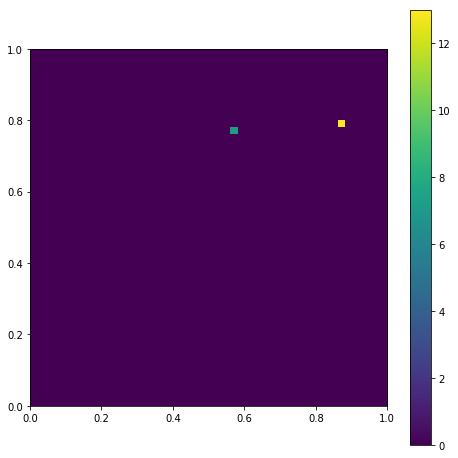

In [8]:
plt.figure(figsize=(8,8))
plt.imshow(performance, extent=[0, 1, 0, 1])
plt.colorbar()

### DNN + CNN